# Axis to Regression Registration Pipeline

## Data loading

In [1]:
from sidus import io, tools as tl, plotting as pl # import input/output, editing tools, plotting as pl  
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ants
from sklearn.metrics import jaccard_score, f1_score
import SimpleITK as sitk
from skimage import exposure
import seaborn as sns
from scipy.stats import ttest_rel
# Fix for Dask DataFrame warning
from dask.config import set
set({"dataframe.query-planning": True})

c:\Users\molanre1\AppData\Local\miniconda3\envs\wsifir-env\lib\site-packages\dask\dataframe\__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


### Load clinical data

In [7]:
# Change file paths to your own
file_path = 'C:/Users/molanre1/Desktop/WSIFIR/'
samples_file = file_path + 'NAT_samples_12.2024.csv'

#Load the axis,regression and tbet clinical data
NAT_samples = pd.read_csv(samples_file)
NAT_samples.head(5)

,redcapid,sampleid,slideid,tbet_sampleid,tbet_slideid,reg_sampleid,reg_slideid,RFS,recurrence,lastfollowup,...,analysis_area,specimen_collection,included,paired,model_rvt,ln_status,tumor,regression,good_tissue,pseudo_patient_id
0,239,101,L1_2,834.0,AP0140001,709.0,LY1,83,1.0,2022-11-10 00:00:00,...,59.987766,Post,1,1,0.0,1,1,0,1,1
1,240,107,L2_4,835.0,AP0140002,710.0,LY2,2,0.0,2016-05-01 00:00:00,...,83.479162,Post,1,1,2.0,0,1,1,1,2
2,242,535,L4_3,837.0,AP0140004,712.0,LY4,34,0.0,2019-03-13 00:00:00,...,25.146146,Post,1,1,0.0,0,0,1,1,4
3,243,112,L5_1,838.0,AP0140005,713.0,LY5,47,0.0,2021-07-04 00:00:00,...,52.582683,Post,1,0,0.0,0,0,1,1,5
4,244,114,L6_1,839.0,AP0140006,714.0,LY6,51,0.0,2016-12-12 00:00:00,...,84.902509,Post,1,0,1.0,0,1,1,1,6


In [3]:
#Get corresponding images on each panel. Each row represents corresponding images
ids = NAT_samples[["sampleid","reg_sampleid","tbet_sampleid","slideid","reg_slideid","tbet_slideid"]].copy()

axis_sampleid = NAT_samples['sampleid']
reg_sampleid = NAT_samples['reg_sampleid']
tbet_sampleid = NAT_samples['tbet_sampleid']
axis_slideid = NAT_samples['slideid']
reg_slideid = NAT_samples['reg_slideid']
tbet_slideid = NAT_samples['tbet_slideid']

#Drop the rows with missing values
ids.dropna(inplace=True)


ids.head(46)

,sampleid,reg_sampleid,tbet_sampleid,slideid,reg_slideid,tbet_slideid
0,101,709.0,834.0,L1_2,LY1,AP0140001
1,107,710.0,835.0,L2_4,LY2,AP0140002
2,535,712.0,837.0,L4_3,LY4,AP0140004
3,112,713.0,838.0,L5_1,LY5,AP0140005
4,114,714.0,839.0,L6_1,LY6,AP0140006
5,118,715.0,840.0,L8_2,LY8,AP0140007
6,536,678.0,841.0,L9_3,AP0060001,AP0140008
7,537,679.0,842.0,L10_3,AP0060002,AP0140009
8,125,716.0,843.0,L11_3,LY11,AP0140010
9,129,717.0,844.0,L12_2,LY12,AP0140011


### Load in images from the database

In [9]:
#Initialize the row indexes for all the images

row_indexes = list(range(len(ids)))

# List to store all images
all_images = []

# Dictionary to store the results of each iteration
results = {}

# Extract the row from the ids table
for row_index in row_indexes:
    selected_row = ids.iloc[row_index]

    # Create variables for each column in the selected row
    reg_sampleid = selected_row['reg_sampleid']
    axis_sampleid = selected_row['sampleid']
    reg_slideid = selected_row['reg_slideid']
    axis_slideid = selected_row['slideid']

    # Convert variables to integers
    reg_sampleid = int(reg_sampleid)
    axis_sampleid = int(axis_sampleid)

    # Save the variables in the dictionary
    results[row_index] = {
        'reg_sampleid': reg_sampleid,
        'axis_sampleid': axis_sampleid,
        'reg_slideid': reg_slideid,
        'axis_slideid': axis_slideid
    }

    # Load the images
    reg_image = io.load_astropath(sampleid=reg_sampleid, sample_path=f'//bki-fs1/data02/Clinical_Specimen_10/{reg_slideid}', cells_table_path=False, cells_boundaries_path=False,cell_annotations_path=False, modaility='astropath')
    axis_image = io.load_astropath(sampleid=axis_sampleid, sample_path=f'//bki-fs1/data02/Clinical_Specimen_2/{axis_slideid}', cells_table_path=False, cells_boundaries_path=False,cell_annotations_path=False, modaility='astropath')

     # Add images to the list
    all_images.extend([reg_image, axis_image])

# Load the project with all images
sp = io.load_project(samples=all_images, merge_tables=True, modality='astropath')

#Display the spatial data
sp

SpatialData object
├── Images
│     ├── 'sampleid_101_image': DataTree[cyx] (8, 49152, 65536), (8, 24576, 32768), (8, 12288, 16384), (8, 6144, 8192), (8, 3072, 4096), (8, 1536, 2048), (8, 768, 1024), (8, 384, 512), (8, 192, 256), (8, 96, 128)
│     ├── 'sampleid_102_image': DataTree[cyx] (8, 32768, 65536), (8, 16384, 32768), (8, 8192, 16384), (8, 4096, 8192), (8, 2048, 4096), (8, 1024, 2048), (8, 512, 1024), (8, 256, 512), (8, 128, 256), (8, 64, 128)
│     ├── 'sampleid_103_image': DataTree[cyx] (8, 32768, 65536), (8, 16384, 32768), (8, 8192, 16384), (8, 4096, 8192), (8, 2048, 4096), (8, 1024, 2048), (8, 512, 1024), (8, 256, 512), (8, 128, 256), (8, 64, 128)
│     ├── 'sampleid_107_image': DataTree[cyx] (8, 49152, 65536), (8, 24576, 32768), (8, 12288, 16384), (8, 6144, 8192), (8, 3072, 4096), (8, 1536, 2048), (8, 768, 1024), (8, 384, 512), (8, 192, 256), (8, 96, 128)
│     ├── 'sampleid_109_image': DataTree[cyx] (8, 49152, 65536), (8, 24576, 32768), (8, 12288, 16384), (8, 6144, 8192), 

In [10]:
len(sp.images)

92

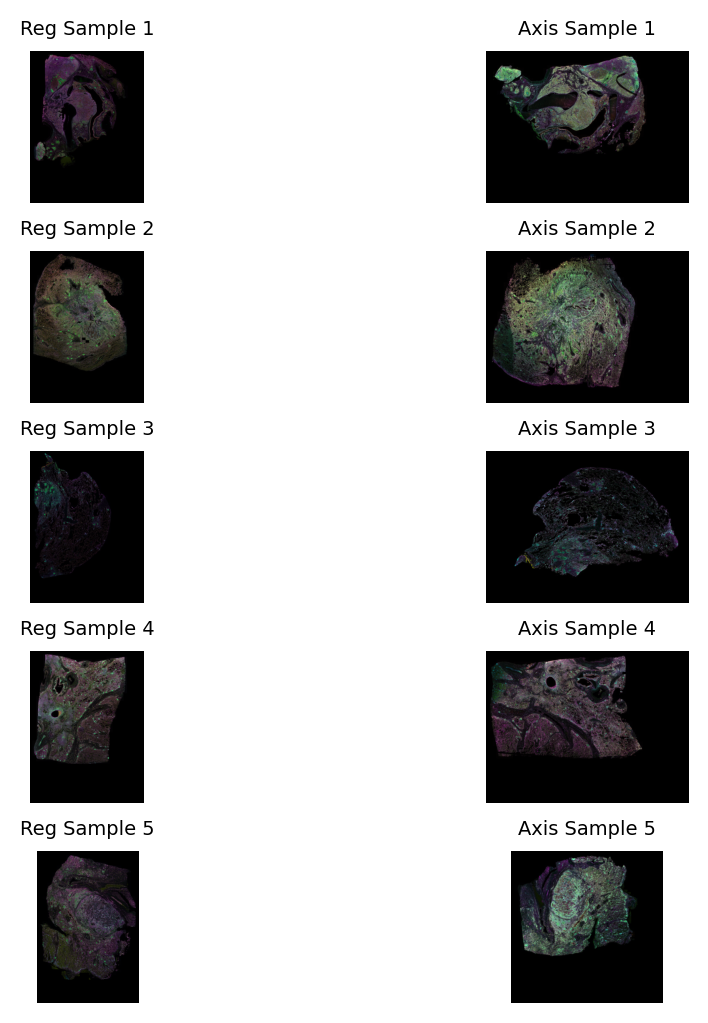

In [11]:
# Plot the first 5 images

pl.SubPlots(
    pl.ShowImage(sdata=sp, sampleid=results[0]['reg_sampleid'], title="Reg Sample 1"),  # reg_sampleid
    pl.ShowImage(sdata=sp, sampleid=results[0]['axis_sampleid'], title="Axis Sample 1"),  # axis_sampleid

    pl.ShowImage(sdata=sp, sampleid=results[1]['reg_sampleid'], title="Reg Sample 2"),  # reg_sampleid
    pl.ShowImage(sdata=sp, sampleid=results[1]['axis_sampleid'], title="Axis Sample 2"),  # axis_sampleid

    pl.ShowImage(sdata=sp, sampleid=results[2]['reg_sampleid'], title="Reg Sample 3"),  # reg_sampleid
    pl.ShowImage(sdata=sp, sampleid=results[2]['axis_sampleid'], title="Axis Sample 3"),  # axis_sampleid
    
    pl.ShowImage(sdata=sp, sampleid=results[3]['reg_sampleid'], title="Reg Sample 4"),  # reg_sampleid
    pl.ShowImage(sdata=sp, sampleid=results[3]['axis_sampleid'], title="Axis Sample 4"),  # axis_sampleid

    pl.ShowImage(sdata=sp, sampleid=results[4]['reg_sampleid'], title="Reg Sample 5"),  # reg_sampleid
    pl.ShowImage(sdata=sp, sampleid=results[4]['axis_sampleid'], title="Axis Sample 5"),  # axis_sampleid

   figsize=(5, 5),

)


## Rigid Registration (Scale 9)

### Load in spatial data 

In [12]:
# Loop through each image in sp.images and crop it
cropped_images = {}
for sampleid in sp.images:
    cropped_images[sampleid] = tl.crop_xarray_image(sp.images[sampleid], scale=9)[0]

# Convert all images to numpy arrays

cropped_images_arrays = {}
for sampleid, cropped_image in cropped_images.items():
    cropped_images_arrays[sampleid] = cropped_image.compute()



In [13]:
# Convert all images to ants images
cropped_images_ants = {}
for sampleid, cropped_image in cropped_images_arrays.items():
    cropped_images_ants[sampleid] = ants.from_numpy(cropped_image)

cropped_images_ants

{'sampleid_709_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (96, 128)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_101_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (128, 96)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_710_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (96, 128)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_107_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (128, 96)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_712_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (96, 128)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_535_image': ANTsIma

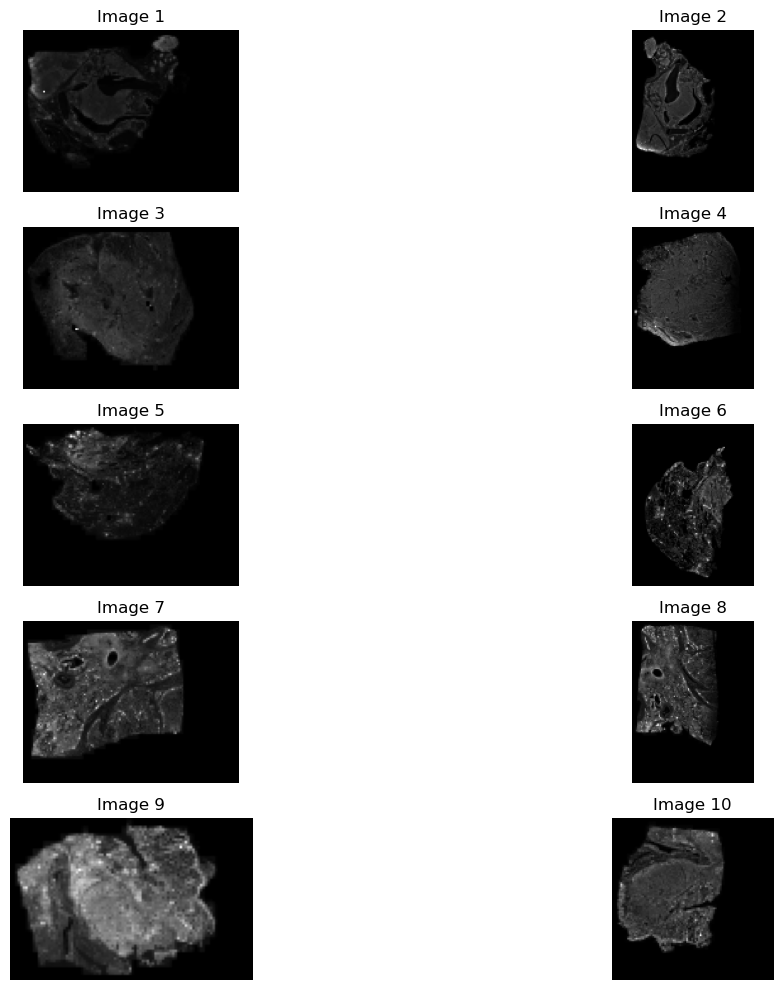

In [15]:
# Plot the first 10 images of cropped images using plt with 5 rows and 2 columns

fig, axes = plt.subplots(5, 2, figsize=(15, 10))
axes = axes.flatten()
for i, (sampleid, cropped_image) in enumerate(cropped_images_ants.items()):
    if i < 10:
        axes[i].imshow(cropped_image.numpy(), cmap='gray')
        axes[i].set_title(f'Image {i+1}')
        axes[i].axis('off')
plt.tight_layout()
plt.show()



### Pad images

In [16]:
# Create a function to pad all images in cropped_images_ants to the same size

def pad_images_to_same_size(images):
    # Get the maximum dimensions
    max_shape = np.max([img.shape for img in images.values()], axis=0)

    # Pad each image to the maximum dimensions
    padded_images = {}
    for sampleid, img in images.items():
        pad_width = [(0, max_dim - img.shape[i]) for i, max_dim in enumerate(max_shape)]
        padded_images[sampleid] = np.pad(img.numpy(), pad_width, mode='constant', constant_values=0)
    return padded_images
# Pad the images
padded_images = pad_images_to_same_size(cropped_images_ants)

# Convert the padded images to ANTs images
padded_images_ants = {}
for sampleid, padded_image in padded_images.items():
    padded_images_ants[sampleid] = ants.from_numpy(padded_image)

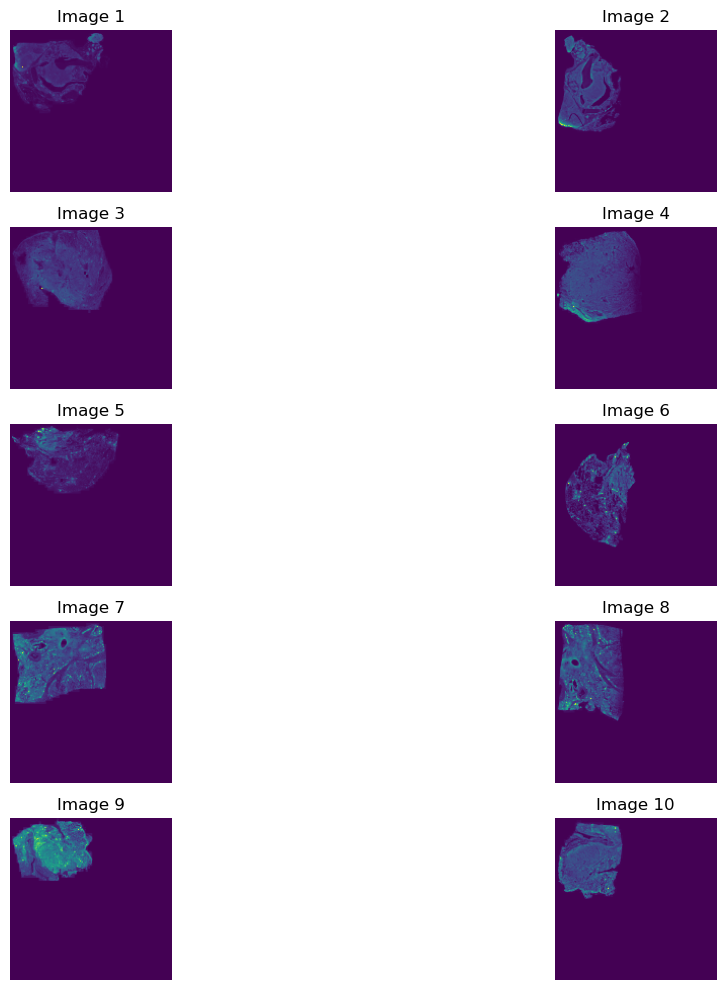

In [17]:
#Plot the first 10 images of padded images using plt with 5 rows and 2 columns
fig, axes = plt.subplots(5, 2, figsize=(15, 10))
axes = axes.flatten()
for i, (sampleid, padded_image) in enumerate(padded_images_ants.items()):
    if i < 10:
        axes[i].imshow(padded_image.numpy())
        axes[i].set_title(f'Image {i+1}')
        axes[i].axis('off')
plt.tight_layout()
plt.show()

In [18]:
# Store odd and even images in separate lists: regression and tbet while keeping the key

# Create lists to store regression and tbet image
# images

regression_images = []
axis_images = []
for i, (sampleid, padded_image) in enumerate(padded_images_ants.items()):
    if i % 2 == 0:  # Even index
        regression_images.append((sampleid, padded_image))
    else:  # Odd index
        axis_images.append((sampleid, padded_image))

In [19]:
regression_images

[('sampleid_709_image',
  ANTsImage
  	 Pixel Type : float (float32)
  	 Components : 1
  	 Dimensions : (160, 160)
  	 Spacing    : (1.0, 1.0)
  	 Origin     : (0.0, 0.0)
  	 Direction  : [1. 0. 0. 1.]),
 ('sampleid_710_image',
  ANTsImage
  	 Pixel Type : float (float32)
  	 Components : 1
  	 Dimensions : (160, 160)
  	 Spacing    : (1.0, 1.0)
  	 Origin     : (0.0, 0.0)
  	 Direction  : [1. 0. 0. 1.]),
 ('sampleid_712_image',
  ANTsImage
  	 Pixel Type : float (float32)
  	 Components : 1
  	 Dimensions : (160, 160)
  	 Spacing    : (1.0, 1.0)
  	 Origin     : (0.0, 0.0)
  	 Direction  : [1. 0. 0. 1.]),
 ('sampleid_713_image',
  ANTsImage
  	 Pixel Type : float (float32)
  	 Components : 1
  	 Dimensions : (160, 160)
  	 Spacing    : (1.0, 1.0)
  	 Origin     : (0.0, 0.0)
  	 Direction  : [1. 0. 0. 1.]),
 ('sampleid_714_image',
  ANTsImage
  	 Pixel Type : float (float32)
  	 Components : 1
  	 Dimensions : (160, 160)
  	 Spacing    : (1.0, 1.0)
  	 Origin     : (0.0, 0.0)
  	 Dire

In [20]:
axis_images

[('sampleid_101_image',
  ANTsImage
  	 Pixel Type : float (float32)
  	 Components : 1
  	 Dimensions : (160, 160)
  	 Spacing    : (1.0, 1.0)
  	 Origin     : (0.0, 0.0)
  	 Direction  : [1. 0. 0. 1.]),
 ('sampleid_107_image',
  ANTsImage
  	 Pixel Type : float (float32)
  	 Components : 1
  	 Dimensions : (160, 160)
  	 Spacing    : (1.0, 1.0)
  	 Origin     : (0.0, 0.0)
  	 Direction  : [1. 0. 0. 1.]),
 ('sampleid_535_image',
  ANTsImage
  	 Pixel Type : float (float32)
  	 Components : 1
  	 Dimensions : (160, 160)
  	 Spacing    : (1.0, 1.0)
  	 Origin     : (0.0, 0.0)
  	 Direction  : [1. 0. 0. 1.]),
 ('sampleid_112_image',
  ANTsImage
  	 Pixel Type : float (float32)
  	 Components : 1
  	 Dimensions : (160, 160)
  	 Spacing    : (1.0, 1.0)
  	 Origin     : (0.0, 0.0)
  	 Direction  : [1. 0. 0. 1.]),
 ('sampleid_114_image',
  ANTsImage
  	 Pixel Type : float (float32)
  	 Components : 1
  	 Dimensions : (160, 160)
  	 Spacing    : (1.0, 1.0)
  	 Origin     : (0.0, 0.0)
  	 Dire

### ANTS Rigid transform 

In [21]:
#Register the regression images to the axis image

registered_images = {}
for i, (reg_sampleid, reg_image) in enumerate(regression_images):
    # Get the corresponding axis image
    axis_sampleid, axis_image = axis_images[i]

    #Conduct an affine initialization

    affine_init = ants.affine_initializer(reg_image, axis_image, txfn=f'C:/Users/molanre1/Desktop/WSIFIR/scale_9_transform/axis_reg/{reg_sampleid}_to_{axis_sampleid}.txt')
        
    # Perform registration
    registered_image = ants.registration(fixed=reg_image, moving=axis_image, type_of_transform='Rigid', initial_transform=affine_init, outprefix=f'C:/Users/molanre1/Desktop/WSIFIR/scale_9_transform/axis_reg/{reg_sampleid}_to_{axis_sampleid}_', verbose=True)

    # Store the registered image
    registered_images[reg_sampleid] = registered_image['warpedmovout']

    #Apply the transformation to the moving image
    transformed_image = ants.apply_transforms(fixed=reg_image, moving=axis_image, transformlist=registered_image['fwdtransforms'])



antsRegistration -d 2 -r C:/Users/molanre1/Desktop/WSIFIR/scale_9_transform/axis_reg/sampleid_709_image_to_sampleid_101_image.txt -m mattes[000002354ABEA6E8,000002354ABEA848,1,32,regular,0.2] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -o [C:/Users/molanre1/Desktop/WSIFIR/scale_9_transform/axis_reg/sampleid_709_image_to_sampleid_101_image_,000002354AD8B7C8,000002354ABE9428] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
antsRegistration -d 2 -r C:/Users/molanre1/Desktop/WSIFIR/scale_9_transform/axis_reg/sampleid_710_image_to_sampleid_107_image.txt -m mattes[000002354ABEA848,000002354ABE9428,1,32,regular,0.2] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -o [C:/Users/molanre1/Desktop/WSIFIR/scale_9_transform/axis_reg/sampleid_710_image_to_sampleid_107_image_,000002354AD8B7C8,000002354ABEA6E8] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
antsRegistration -d 2 -r C:/Users/molanre1/Desktop/WSIFIR/scale_9_transform/axis_reg/s

In [22]:
#Read the transformation matrices using ants.read_transform

transformation_matrices = {}
for i, (reg_sampleid, reg_image) in enumerate(regression_images):
    # Get the corresponding axis image
    axis_sampleid, axis_image = axis_images[i]

    # Read the transformation matrix
    transformation_matrix = ants.read_transform(f'C:/Users/molanre1/Desktop/WSIFIR/scale_9_transform/axis_reg/{reg_sampleid}_to_{axis_sampleid}_0GenericAffine.mat')

    # Store the transformation matrix
    transformation_matrices[reg_sampleid] = transformation_matrix

# Get the parameters and fixed parameters of the transformation matrices
transformation_parameters = {}
for sampleid, matrix in transformation_matrices.items():
    transformation_parameters[sampleid] = {
        'parameters': matrix.parameters,
        'fixed_parameters': matrix.fixed_parameters
    }

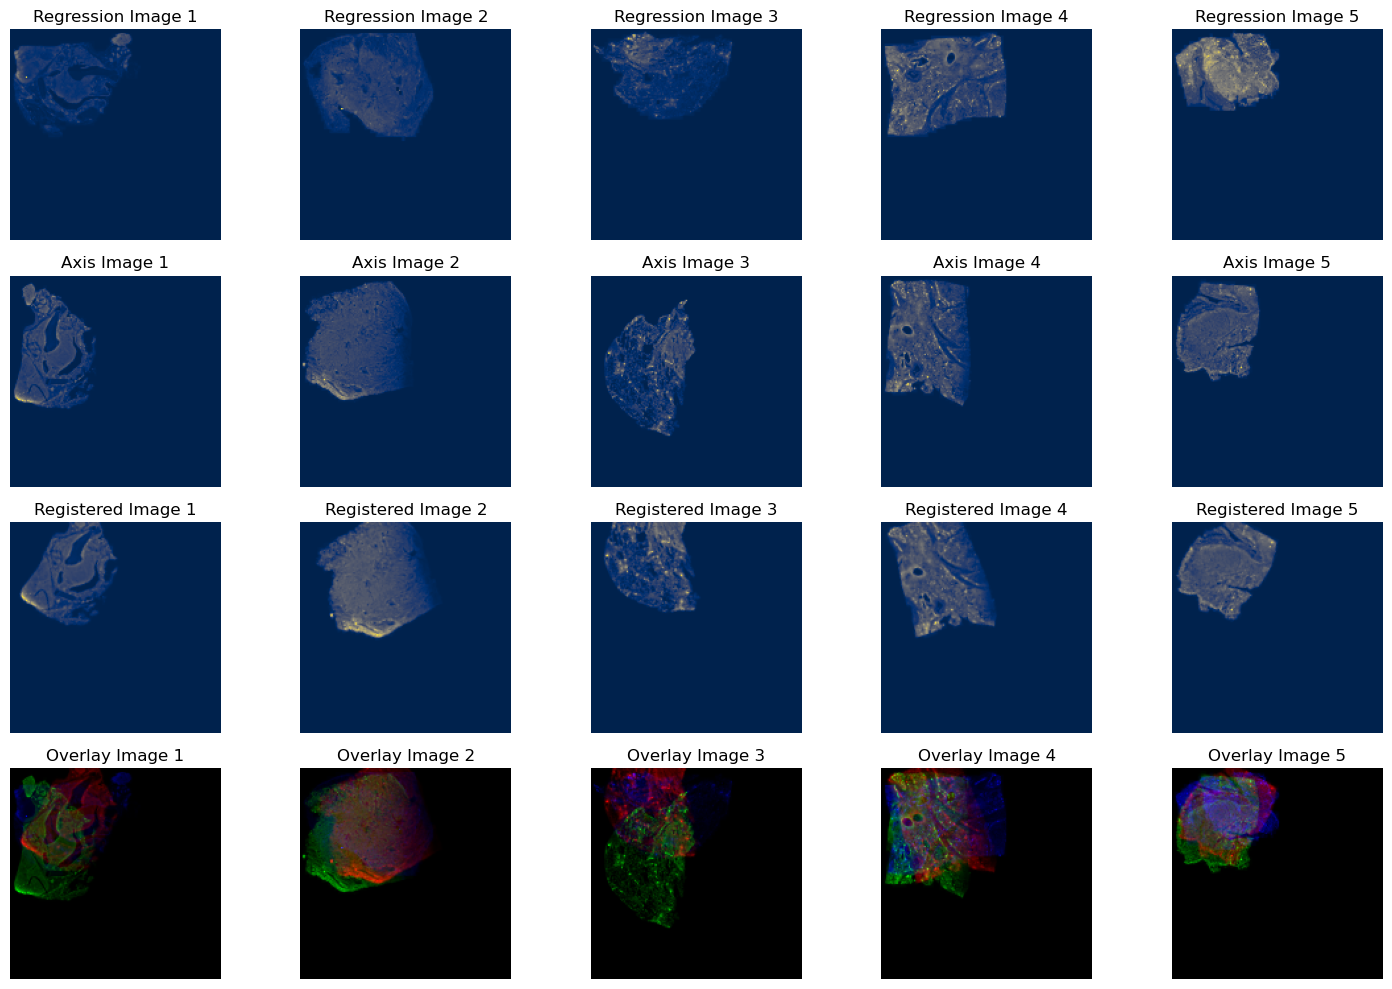

In [23]:
# Plot the first 5 regression images in one row, the corresponding tbet images in the second row,
# the registered images in the third row, and the overlay images in the last row.

fig, axes = plt.subplots(4, 5, figsize=(15, 10))
axes = axes.flatten()

# Plot regression images
for i, (sampleid, padded_image) in enumerate(regression_images):
    if i < 5:
        axes[i].imshow(padded_image.numpy(), cmap='cividis')
        axes[i].set_title(f'Regression Image {i+1}')
        axes[i].axis('off')

# Plot axis images
for i, (sampleid, padded_image) in enumerate(axis_images):
    if i < 5:
        axes[i + 5].imshow(padded_image.numpy(), cmap='cividis')
        axes[i + 5].set_title(f'Axis Image {i+1}')
        axes[i + 5].axis('off')

# Plot registered images
for i, (sampleid, padded_image) in enumerate(registered_images.items()):
    if i < 5:
        axes[i + 10].imshow(padded_image.numpy(), cmap='cividis')
        axes[i + 10].set_title(f'Registered Image {i+1}')
        axes[i + 10].axis('off')

# Plot overlay images
for i, (reg_sampleid, reg_image) in enumerate(regression_images):
    if i < 5:
        # Get the corresponding tbet image
        axis_sampleid, axis_image = axis_images[i]

        # Get the registered image
        registered_image = registered_images[reg_sampleid]

        # Normalize the images to 0-1 range
        registered_image = (registered_image - registered_image.min()) / (registered_image.max() - registered_image.min())
        axis_image = (axis_image - axis_image.min()) / (axis_image.max() - axis_image.min())
        reg_image = (reg_image - reg_image.min()) / (reg_image.max() - reg_image.min())

        # Create a color image by stacking the images along the third dimension
        color_image = np.zeros((registered_image.shape[0], registered_image.shape[1], 3), dtype=np.float32)
        color_image[..., 0] = registered_image.numpy()  # Red channel (registered image)
        color_image[..., 1] = axis_image.numpy()  # Green channel (tbet image)
        color_image[..., 2] = reg_image.numpy()  # Blue channel (regression image)

        axes[i + 15].imshow(color_image)
        axes[i + 15].set_title(f'Overlay Image {i+1}')
        axes[i + 15].axis('off')

plt.tight_layout()
plt.show()

### Metrics

In [24]:
#Compute mutual information, cross correlation, mse between the fixed regression and moving axis images 

def compute_metrics(fixed_image, moving_image):

    # Compute Mutual Information
    mutual_info = ants.image_mutual_information(fixed_image, moving_image)

    # Compute Cross Correlation
    cross_corr = ants.math.image_similarity(fixed_image, moving_image,'Correlation')

    # Compute Mean Squared Error
    mse = ants.math.image_similarity(fixed_image, moving_image,'MeanSquares')

    #Binarize the images
    fixed_image_bin = (fixed_image.numpy()> 0.5).astype(int)
    moving_image_bin =  (moving_image.numpy() > 0.5).astype(int)
    # Compute Jaccard Index
    jaccard_index = jaccard_score(fixed_image_bin.flatten(), moving_image_bin.flatten(), average='weighted')
    
    #Compute the Dice coefficient
    f1 = f1_score(fixed_image_bin.flatten(), moving_image_bin.flatten(), average='weighted')

    # Get image from array
    fixed_image = sitk.GetImageFromArray(fixed_image.numpy())
    moving_image = sitk.GetImageFromArray(moving_image.numpy())

    #Compute the Hausdorff distance
    hausdoroff_distance = sitk.HausdorffDistanceImageFilter()
    hausdoroff_distance.Execute(fixed_image, moving_image)
    hausdoroff_distance_value = hausdoroff_distance.GetHausdorffDistance()

    return mutual_info, cross_corr, mse, jaccard_index, f1, hausdoroff_distance_value


In [25]:
#Create a dataframe with the regression and tbet images

metrics_df = pd.DataFrame(columns=['reg_sampleid', 'axis_sampleid', 'Mutual Information', 'Cross Correlation', 'Mean Squared Error', 'Jaccard Index', 'F1 Score', 'Hausdorff Distance'])

# Loop through each image in the registered images

for i, (reg_sampleid, reg_image) in enumerate(regression_images):
    # Get the corresponding tbet image
    axis_sampleid, axis_image = axis_images[i]

    # Compute metrics
    mutual_info, cross_corr, mse, jaccard_index, f1, hausdorff_distance_value = compute_metrics(reg_image, axis_image)

    # Concantenate to the dataframe
    metrics_df = pd.concat([metrics_df, pd.DataFrame({
        'reg_sampleid': [reg_sampleid],
        'axis_sampleid': [axis_sampleid],
        'Mutual Information': [mutual_info],
        'Cross Correlation': [cross_corr],
        'Mean Squared Error': [mse],
        'Jaccard Index': [jaccard_index],
        'F1 Score': [f1],
        'Hausdorff Distance': [hausdorff_distance_value]
    })], ignore_index=True)


metrics_df.head(5)

C:\Users\molanre1\AppData\Local\Temp\2\ipykernel_31948\4031139364.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, pd.DataFrame({


,reg_sampleid,axis_sampleid,Mutual Information,Cross Correlation,Mean Squared Error,Jaccard Index,F1 Score,Hausdorff Distance
0,sampleid_709_image,sampleid_101_image,-0.065516,-0.101220,2.743987,0.767091,0.855049,44.407207
1,sampleid_710_image,sampleid_107_image,-0.249988,-0.355480,1.040170,0.809653,0.890759,17.464249
2,sampleid_712_image,sampleid_535_image,-0.041597,-0.027519,1.853853,0.685895,0.791194,53.000000
3,sampleid_713_image,sampleid_112_image,-0.199832,-0.316010,0.601612,0.786195,0.873698,29.000000
4,sampleid_714_image,sampleid_114_image,-0.184843,-0.364730,0.682608,0.868651,0.924843,19.235384


In [26]:
#Create a dataframe for the registered images and regression images
metrics_registered_images_df = pd.DataFrame(columns=['reg_sampleid', 'axis_sampleid', 'Mutual Information', 'Cross Correlation', 'Mean Squared Error', 'Jaccard Index', 'F1 Score', 'Hausdorff Distance'])
# Loop through each image in the registered images

for i, (reg_sampleid, reg_image) in enumerate(registered_images.items()):
    # Get the corresponding regression image
    reg_sampleid, reg_image = regression_images[i]

#Compute metrics
    mutual_info, cross_corr, mse, jaccard_index, f1, hausdorff_distance_value = compute_metrics(reg_image, registered_image)


 # Concatenate to the dataframe
    metrics_registered_images_df = pd.concat([metrics_registered_images_df, pd.DataFrame({
            'reg_sampleid': [reg_sampleid],
            'axis_sampleid': [axis_sampleid],
            'Mutual Information': [mutual_info],
            'Cross Correlation': [cross_corr],
            'Mean Squared Error': [mse],
            'Jaccard Index': [jaccard_index],
            'F1 Score': [f1],
            'Hausdorff Distance': [hausdorff_distance_value]
        })], ignore_index=True)
    

metrics_registered_images_df.head(5)


        


C:\Users\molanre1\AppData\Local\Temp\2\ipykernel_31948\3078503402.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_registered_images_df = pd.concat([metrics_registered_images_df, pd.DataFrame({


,reg_sampleid,axis_sampleid,Mutual Information,Cross Correlation,Mean Squared Error,Jaccard Index,F1 Score,Hausdorff Distance
0,sampleid_709_image,sampleid_196_image,-0.169383,-0.318804,1.052597,0.694676,0.758776,21.189620
1,sampleid_710_image,sampleid_196_image,-0.209823,-0.428834,0.790324,0.583489,0.662621,36.235342
2,sampleid_712_image,sampleid_196_image,-0.179581,-0.334345,0.456652,0.688109,0.753053,28.160256
3,sampleid_713_image,sampleid_196_image,-0.219146,-0.381008,0.717418,0.605933,0.682601,32.649655
4,sampleid_714_image,sampleid_196_image,-0.275613,-0.549933,0.558976,0.743375,0.799071,16.000000


In [27]:
metrics_df.drop(columns=['reg_sampleid', 'axis_sampleid'], inplace=True)
metrics_registered_images_df.drop(columns=['reg_sampleid', 'axis_sampleid'], inplace=True)

In [28]:
# Compute the mean and standard deviation of the metrics
metrics_mean = metrics_df.mean()
metrics_std = metrics_df.std()
metrics_registered_images_mean = metrics_registered_images_df.mean()
metrics_registered_images_std = metrics_registered_images_df.std()
# Create a dataframe with the mean and standard deviation of the metrics
metrics_mean_df = pd.DataFrame({
    'Mean': metrics_mean,
    'Standard Deviation': metrics_std
})
metrics_registered_images_mean_df = pd.DataFrame({
    'Mean': metrics_registered_images_mean,
    'Standard Deviation': metrics_registered_images_std
})

# Concatenate the two dataframes
metrics_combined_df = pd.concat([metrics_mean_df['Mean'], metrics_registered_images_mean_df['Mean'], metrics_mean_df['Standard Deviation'], metrics_registered_images_mean_df['Standard Deviation']], axis=1) 
metrics_combined_df.columns = ['Mean', 'Mean Registered', 'Standard Deviation', 'Standard Deviation Registered']
metrics_combined_df

,Mean,Mean Registered,Standard Deviation,Standard Deviation Registered
Mutual Information,-0.106764,-0.170054,0.079774,0.065976
Cross Correlation,-0.184631,-0.321734,0.156791,0.147128
Mean Squared Error,2.077974,0.493349,1.348767,0.300090
Jaccard Index,0.790892,0.729531,0.093951,0.111338
F1 Score,0.868216,0.785599,0.065080,0.091461
Hausdorff Distance,38.406497,32.290204,16.652852,13.860226


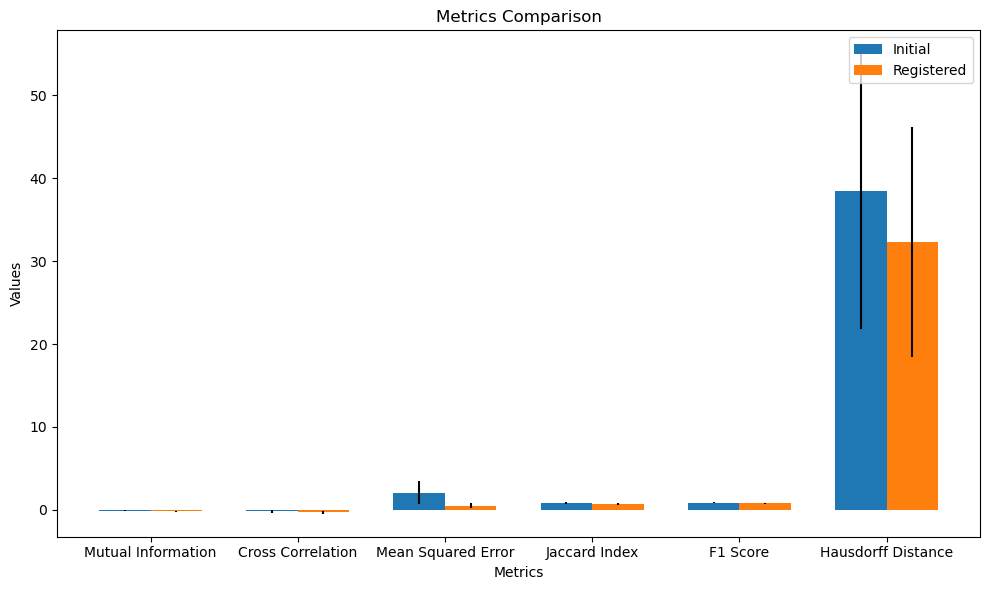

In [29]:
# Create grouped bar plots for the metrics and metrics_registered_images for each metric without hausdorff distance

def plot_grouped_bar_chart(df1, df2, title):
    # Set the figure size
    plt.figure(figsize=(10, 6))

    # Set the bar width
    bar_width = 0.35

    # Set the x locations for the bars
    x = np.arange(len(df1))

    # Create the bars for df1
    plt.bar(x, df1['Mean'], yerr=df1['Standard Deviation'], width=bar_width, label='Initial')

    # Create the bars for df2
    plt.bar(x + bar_width, df2['Mean'], yerr=df2['Standard Deviation'], width=bar_width, label='Registered')

    # Add labels and title
    plt.xlabel('Metrics')
    plt.ylabel('Values')
    plt.title(title)
    plt.xticks(x + bar_width / 2, df1.index)
    plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()
# Plot the grouped bar chart for metrics_df and metrics_registered_images_df
plot_grouped_bar_chart(metrics_mean_df, metrics_registered_images_mean_df, 'Metrics Comparison')

In [30]:
# Compute the difference between the metrics of the mean and standard deviation OF the registered images and the regression images
diff_mean = metrics_registered_images_mean_df['Mean'] - metrics_mean_df['Mean']


# Create a dataframe with the difference between the metrics of the mean and standard deviation
diff_df = pd.DataFrame({
    'Mean Difference': diff_mean,
})

diff_df

,Mean Difference
Mutual Information,-0.063290
Cross Correlation,-0.137103
Mean Squared Error,-1.584625
Jaccard Index,-0.061361
F1 Score,-0.082616
Hausdorff Distance,-6.116292


In [31]:
#Save the dataframe to a csv file
diff_df.to_csv('C:/Users/molanre1/Desktop/WSIFIR/scale_9_transform/axis_reg_metrics_diff_mean_df.csv', index=False)

In [32]:
#Convert each set of corresponding tissue slices into a DataFrame
#Each row has the same tissue, but 2 different slices representing the same tissue stained with regression and tbet panels

# Create a DataFrame to store the merged images
merged_df = pd.DataFrame(columns=['reg_sampleid', 'axis_sampleid','final_image_parameters', 'final_image_fixed_parameters'])

# Loop through each image and concate to the DataFrame

for i, (reg_sampleid, reg_image) in enumerate(registered_images.items()):
    # Get the corresponding tbet image
    axis_sampleid, axis_image = axis_images[i]

    # Get the transformation matrix
    transformation_matrix = transformation_matrices[reg_sampleid]

    # Append the metrics to the DataFrame
    merged_df = pd.concat([merged_df, pd.DataFrame({
        'reg_sampleid': [reg_sampleid],
        'axis_sampleid': [axis_sampleid],
        'final_image_parameters': [transformation_matrix.parameters],
        'final_image_fixed_parameters': [transformation_matrix.fixed_parameters]
    })], ignore_index=True)

merged_df.head(10)

,reg_sampleid,axis_sampleid,final_image_parameters,final_image_fixed_parameters
0,sampleid_709_image,sampleid_101_image,"[0.930496335029602, -0.3663012683391571, 0.366...","[35.215389251708984, 41.98567581176758]"
1,sampleid_710_image,sampleid_107_image,"[0.9534813761711121, 0.3014521598815918, -0.30...","[42.120697021484375, 52.78548049926758]"
2,sampleid_712_image,sampleid_535_image,"[0.9264296889305115, 0.3764982521533966, -0.37...","[28.47519302368164, 50.77205276489258]"
3,sampleid_713_image,sampleid_112_image,"[0.9481428861618042, 0.318290650844574, -0.318...","[39.62575912475586, 44.546478271484375]"
4,sampleid_714_image,sampleid_114_image,"[0.915287435054779, -0.4090421795845032, 0.407...","[30.321826934814453, 41.447025299072266]"
5,sampleid_715_image,sampleid_118_image,"[0.936939537525177, 0.39057472348213196, -0.36...","[36.37406921386719, 45.331546783447266]"
6,sampleid_678_image,sampleid_536_image,"[0.9194487929344177, -0.3932098150253296, 0.39...","[39.46842575073242, 36.75742721557617]"
7,sampleid_679_image,sampleid_537_image,"[0.9505236744880676, 0.3081101179122925, -0.30...","[10.761759757995605, 11.912997245788574]"
8,sampleid_716_image,sampleid_125_image,"[0.9284784197807312, -0.37157270312309265, 0.3...","[31.23196792602539, 37.17987823486328]"
9,sampleid_717_image,sampleid_129_image,"[0.9282060265541077, -0.3720666468143463, 0.37...","[32.858036041259766, 43.60976791381836]"


In [33]:
# Save the merged DataFrame to a CSV file
merged_df.to_csv('C:/Users/molanre1/Desktop/WSIFIR/xform_reg_to_axis_scale_9.csv', index=False)

## Rigid Regression (Scale 7)

### Load in spatial data

In [46]:
# Loop through each image in sp.images and crop it
cropped_images_2 = {}
for sampleid in sp.images:
    cropped_images_2[sampleid] = tl.crop_xarray_image(sp.images[sampleid], scale=7)[0]


In [47]:
# Convert all images to numpy arrays
cropped_images_arrays_2 = {}
for sampleid, cropped_image in cropped_images_2.items():
    cropped_images_arrays_2[sampleid] = cropped_image.compute()

In [48]:
#Convert all images to ants images
cropped_images_ants_2 = {}
for sampleid, cropped_image in cropped_images_arrays_2.items():
    cropped_images_ants_2[sampleid] = ants.from_numpy(cropped_image)
cropped_images_ants_2

{'sampleid_709_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (384, 512)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_101_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (512, 384)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_710_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (384, 512)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_107_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (512, 384)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_712_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (384, 512)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_535_image': AN

### Pad images

In [49]:
# Pad the images
padded_images_2 = pad_images_to_same_size(cropped_images_ants_2)

# Convert the padded images to ANTs images
padded_images_ants_2 = {}
for sampleid, padded_image in padded_images_2.items():
    padded_images_ants_2[sampleid] = ants.from_numpy(padded_image)

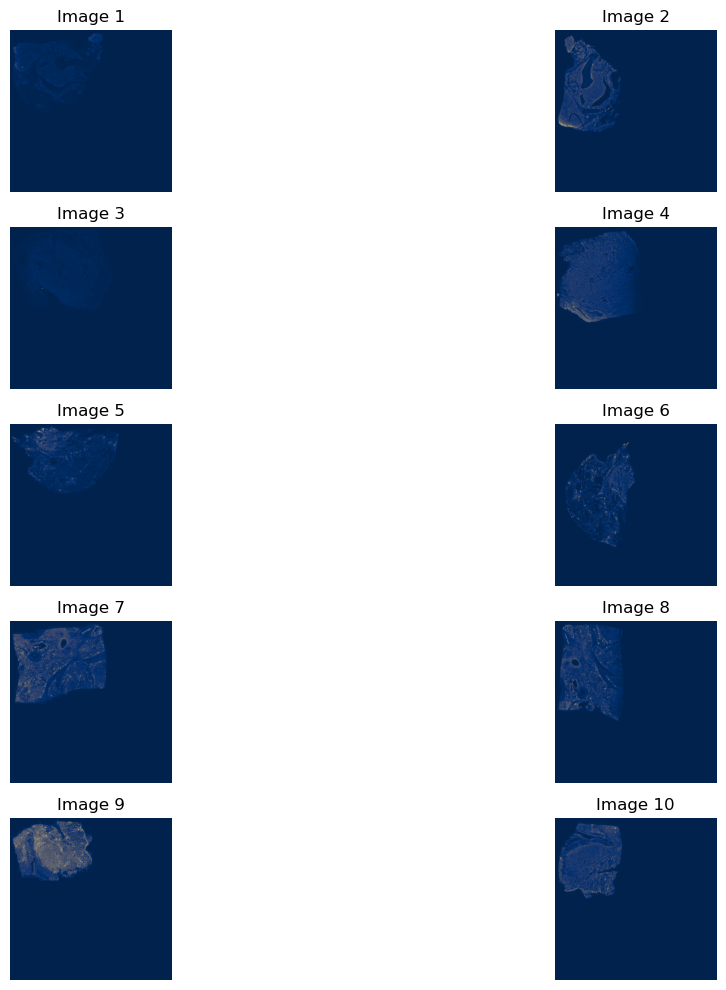

In [53]:

# Plot the first 10 images of padded images using plt with 5 rows and 2 columns
fig, axes = plt.subplots(5, 2, figsize=(15, 10))
axes = axes.flatten()
for i, (sampleid, padded_image) in enumerate(padded_images_ants_2.items()):
    if i < 10:
        axes[i].imshow(padded_image.numpy(), cmap='cividis')
        axes[i].set_title(f'Image {i+1}')
        axes[i].axis('off')
plt.tight_layout()
plt.show()

In [64]:
#Store odd and even images in separate lists: regression and tbet while keeping the key
# Create lists to store regression and tbet image
# images
regression_images_2 = []
axis_images_2 = []
for i, (sampleid, padded_image) in enumerate(padded_images_ants_2.items()):
    if i % 2 == 0:  # Even index
        regression_images_2.append((sampleid, padded_image))
    else:  # Odd index
        axis_images_2.append((sampleid, padded_image))

### Scale and apply registration parameters at lower resolution to higher resolution image

In [65]:
def compute_scaling_factor(higher_res_scale, lower_res_scale):
    """
    Compute the scaling factor based on the image transformations.
    """
    # Directly compute the scaling factor as a scalar
    return lower_res_scale / higher_res_scale

def scale_transform(transform_path, scaling_factors):
    """
    Scale a 2D affine transformation matrix while preserving rotation components.
    
    Parameters:
        transform_path (str): Path to the original transformation matrix (.mat file).
        scaling_factors (list or float): Scaling factors for translation components. 
                                         Can be a scalar or a list of 2 values for 2D transformations.
    
    Returns:
        str: Path to the scaled transformation matrix.
    """
    try:
        # Read the transformation matrix
        transform = ants.read_transform(transform_path)
        
        # Ensure the transform is 2D
        if transform.dimension != 2:
            raise ValueError("This function only supports 2D transformations.")
        
        # Extract the transformation parameters
        parameters = np.array(transform.parameters)  # Convert to a NumPy array for easier manipulation
        
        # Validate scaling_factors
        if isinstance(scaling_factors, (int, float)):  # If scalar, apply uniformly
            scaling_factors = [scaling_factors] * 2
        elif len(scaling_factors) != 2:
            raise ValueError("Scaling factors must be a scalar or a list of 2 values for 2D transformations.")
        
        # Scale only the translation components (last two parameters for tx, ty in 2D affine)
        scaled_parameters = parameters.copy()
        if len(parameters) >= 6:  # Ensure there are enough parameters for a 2D affine transform
            scaled_parameters[4:6] *= scaling_factors  # Scale translation components (tx, ty)
        else:
            raise ValueError("Transformation parameters do not have enough components to scale translation.")
        
        # Create a new transform with the scaled parameters
        scaled_transform = ants.create_ants_transform(
            transform_type=transform.type,  # Use the same transform type
            dimension=transform.dimension,  # Use the same dimension (2D)
            parameters=scaled_parameters.tolist(),  # Convert back to a list
            fixed_parameters=transform.fixed_parameters  # Keep the fixed parameters unchanged
        )
        
        # Save the scaled transformation matrix
        scaled_transform_path = transform_path.replace('.mat', '_scaled.mat')
        ants.write_transform(scaled_transform, scaled_transform_path)
        
        return scaled_transform_path
    
    except Exception as e:
        raise RuntimeError(f"Error scaling transform: {e}")

In [66]:
#Compute the scaling factor between an image from scale 9 and scale 7

scaling_factor_1 = compute_scaling_factor(sp.images[f'{list(sp.images)[0]}']['scale7'].image.transform['scale0'].scale[0], sp.images[f'{list(sp.images)[0]}']['scale9'].image.transform['scale0'].scale[0])

#Convert the scaling factors to be floats
scaling_factor_1 = float(scaling_factor_1)

In [67]:
#For each image in the registered images, scale the transformation matrix
for i, (reg_sampleid, reg_image) in enumerate(registered_images.items()):
    # Get the corresponding axis image
    axis_sampleid, axis_image = axis_images[i]

    # Get the transformation matrix
    transformation_matrix = transformation_matrices[reg_sampleid]

    # Scale the transformation matrix
    scaled_transform_path = scale_transform(f'C:/Users/molanre1/Desktop/WSIFIR/scale_9_transform/axis_reg/{reg_sampleid}_to_{axis_sampleid}_0GenericAffine.mat', scaling_factor_1)

    # Store the scaled transformation matrix
    transformation_matrices[reg_sampleid] = scaled_transform_path

### ANTS Rigid transform

In [68]:
#Perform the registration using the scaled transformation matrix
registered_images_scaled = {}

for i, (reg_sampleid, reg_image) in enumerate(regression_images_2):
    # Get the corresponding axis image
    axis_sampleid, axis_image = axis_images_2[i]

    # Perform registration with the scaled transformation matrix
    registered_image_scaled = ants.registration(fixed=reg_image, moving=axis_image, type_of_transform='Rigid', initial_transform=transformation_matrices[reg_sampleid], outprefix=f'C:/Users/molanre1/Desktop/WSIFIR/scale_7_transform/axis_reg/{reg_sampleid}_to_{axis_sampleid}_', verbose=True)

    # Store the registered image
    registered_images_scaled[reg_sampleid] = registered_image_scaled['warpedmovout']


antsRegistration -d 2 -r C:/Users/molanre1/Desktop/WSIFIR/scale_9_transform/axis_reg/sampleid_709_image_to_sampleid_101_image_0GenericAffine_scaled.mat -m mattes[0000026543C12168,0000026543A9CE48,1,32,regular,0.2] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -o [C:/Users/molanre1/Desktop/WSIFIR/scale_7_transform/axis_reg/sampleid_709_image_to_sampleid_101_image_,000002650C22D1E8,0000026516DFD708] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
antsRegistration -d 2 -r C:/Users/molanre1/Desktop/WSIFIR/scale_9_transform/axis_reg/sampleid_710_image_to_sampleid_107_image_0GenericAffine_scaled.mat -m mattes[0000026516DFD708,000002650C22D1E8,1,32,regular,0.2] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -o [C:/Users/molanre1/Desktop/WSIFIR/scale_7_transform/axis_reg/sampleid_710_image_to_sampleid_107_image_,0000026543C12168,0000026543A9CE48] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
antsRegistration -d 2 -r C:/Users/molanre1

In [69]:
#Read the transformation matrices using ants.read_transform
transformation_matrices_scaled = {}
for i, (reg_sampleid, reg_image) in enumerate(regression_images_2):
    # Get the corresponding axis image
    axis_sampleid, axis_image = axis_images_2[i]

    # Read the transformation matrix
    transformation_matrix = ants.read_transform(f'C:/Users/molanre1/Desktop/WSIFIR/scale_7_transform/axis_reg/{reg_sampleid}_to_{axis_sampleid}_0GenericAffine.mat')

    # Store the transformation matrix
    transformation_matrices_scaled[reg_sampleid] = transformation_matrix

# Get the parameters and fixed parameters of the transformation matrices
transformation_parameters_scaled = {}
for sampleid, matrix in transformation_matrices_scaled.items():
    transformation_parameters_scaled[sampleid] = {
        'parameters': matrix.parameters,
        'fixed_parameters': matrix.fixed_parameters
    }

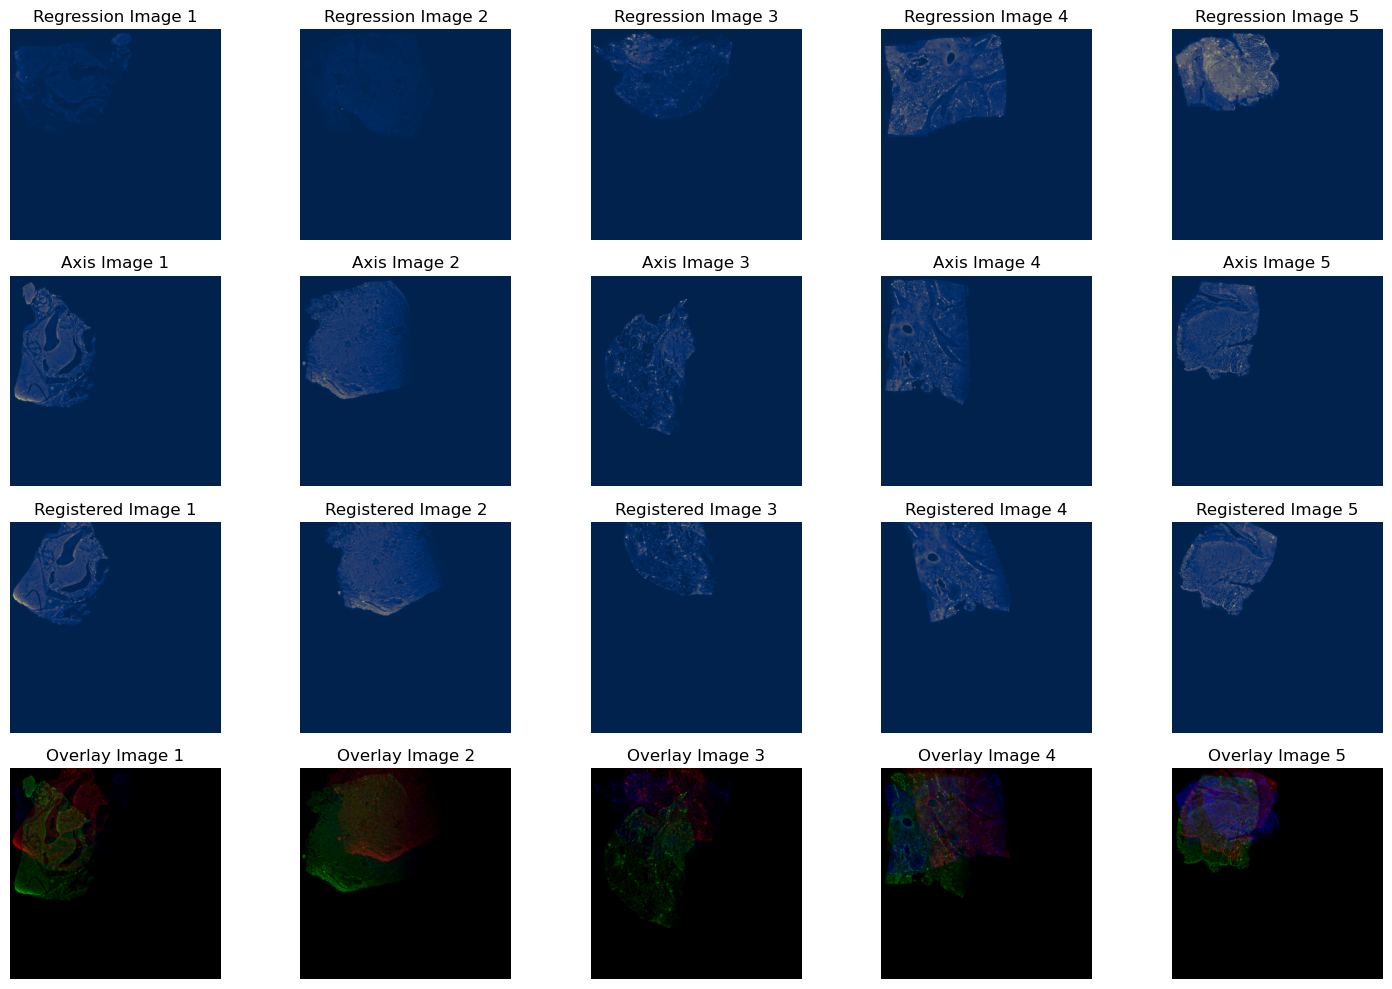

In [70]:
# Plot the first 5 regression images in one row, the corresponding axis images in the second row,
# the registered images in the third row, and the overlay images in the last row.

fig, axes = plt.subplots(4, 5, figsize=(15, 10))
axes = axes.flatten()
# Plot regression images
for i, (sampleid, padded_image) in enumerate(regression_images_2):
    if i < 5:
        axes[i].imshow(padded_image.numpy(), cmap='cividis')
        axes[i].set_title(f'Regression Image {i+1}')
        axes[i].axis('off')
# Plot axis images
for i, (sampleid, padded_image) in enumerate(axis_images_2):
    if i < 5:
        axes[i + 5].imshow(padded_image.numpy(), cmap='cividis')
        axes[i + 5].set_title(f'Axis Image {i+1}')
        axes[i + 5].axis('off')
# Plot registered images
for i, (sampleid, padded_image) in enumerate(registered_images_scaled.items()):
    if i < 5:
        axes[i + 10].imshow(padded_image.numpy(), cmap='cividis')
        axes[i + 10].set_title(f'Registered Image {i+1}')
        axes[i + 10].axis('off')
# Plot overlay images

for i, (reg_sampleid, reg_image) in enumerate(regression_images_2):
    if i < 5:
        # Get the corresponding tbet image
        axis_sampleid, axis_image = axis_images_2[i]

        # Get the registered image
        registered_image = registered_images_scaled[reg_sampleid]

        # Normalize the images to 0-1 range
        registered_image = (registered_image - registered_image.min()) / (registered_image.max() - registered_image.min())
        axis_image = (axis_image - axis_image.min()) / (axis_image.max() - axis_image.min())
        reg_image = (reg_image - reg_image.min()) / (reg_image.max() - reg_image.min())

        # Create a color image by stacking the images along the third dimension
        color_image = np.zeros((registered_image.shape[0], registered_image.shape[1], 3), dtype=np.float32)
        color_image[..., 0] = registered_image.numpy()  # Red channel (registered image)
        color_image[..., 1] = axis_image.numpy()  # Green channel (tbet image)
        color_image[..., 2] = reg_image.numpy()  # Blue channel (regression image)

        axes[i + 15].imshow(color_image)
        axes[i + 15].set_title(f'Overlay Image {i+1}')
        axes[i + 15].axis('off')

plt.tight_layout()
plt.show()

### Metrics

In [71]:
#Create a DataFrame to store the metrics
metrics_df_2 = pd.DataFrame(columns=['reg_sampleid', 'axis_sampleid', 'mutual_info', 'cross_corr', 'mse', 'jaccard_index', 'f1_score', 'hausdorff_distance'])
# Loop through each image and compute the metrics

for i, (reg_sampleid, reg_image) in enumerate(regression_images_2):
    # Get the corresponding tbet image
    axis_sampleid, axis_image = axis_images_2[i]

    # Compute the metrics
    mutual_info, cross_corr, mse, jaccard_index, f1, hausdorff_distance = compute_metrics(reg_image, axis_image)

    # Append the metrics to the DataFrame
    metrics_df_2 = pd.concat([metrics_df_2, pd.DataFrame({
        'reg_sampleid': [reg_sampleid],
        'axis_sampleid': [axis_sampleid],
        'mutual_info': [mutual_info],
        'cross_corr': [cross_corr],
        'mse': [mse],
        'jaccard_index': [jaccard_index],
        'f1_score': [f1],
        'hausdorff_distance': [hausdorff_distance]
    })], ignore_index=True)
metrics_df_2.head(10)

C:\Users\molanre1\AppData\Local\Temp\2\ipykernel_24632\1078625495.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df_2 = pd.concat([metrics_df_2, pd.DataFrame({


,reg_sampleid,axis_sampleid,mutual_info,cross_corr,mse,jaccard_index,f1_score,hausdorff_distance
0,sampleid_709_image,sampleid_101_image,-0.015209,-0.076994,3.348662,0.770608,0.856321,180.405100
1,sampleid_710_image,sampleid_107_image,-0.048184,-0.285879,1.314720,0.803241,0.886230,70.384657
2,sampleid_712_image,sampleid_535_image,-0.010890,-0.016144,2.690109,0.714345,0.809240,210.000000
3,sampleid_713_image,sampleid_112_image,-0.126914,-0.223252,0.862567,0.777906,0.867232,114.000000
4,sampleid_714_image,sampleid_114_image,-0.160728,-0.288462,0.893653,0.870748,0.925861,74.303432
5,sampleid_715_image,sampleid_118_image,-0.081426,-0.222164,1.632451,0.746177,0.843981,161.548754
6,sampleid_678_image,sampleid_536_image,-0.000955,-0.002404,1.555201,0.880164,0.920911,246.130047
7,sampleid_679_image,sampleid_537_image,-0.000105,-0.000070,0.491053,0.971317,0.980943,249.615705
8,sampleid_716_image,sampleid_125_image,-0.121765,-0.322429,0.814861,0.831323,0.898997,143.735869
9,sampleid_717_image,sampleid_129_image,-0.132872,-0.204290,0.896580,0.827497,0.898473,101.000000


In [72]:
metrics_df_2.drop(columns=['reg_sampleid', 'axis_sampleid'], inplace=True)

In [73]:
# Create a DataFrame to store the metrics between the registered images and the regression images
metrics_df_registered_2 = pd.DataFrame(columns=['reg_sampleid', 'axis_sampleid', 'mutual_info', 'cross_corr', 'mse', 'jaccard_index', 'f1_score', 'hausdorff_distance'])
# Loop through each image and compute the metrics
for i, (reg_sampleid, reg_image) in enumerate(registered_images_scaled.items()):
    # Get the corresponding tbet image
    axis_sampleid, axis_image = axis_images_2[i]

    # Compute the metrics
    mutual_info, cross_corr, mse, jaccard_index, f1, hausdorff_distance = compute_metrics(reg_image,axis_image)

    # Append the metrics to the DataFrame
    metrics_df_registered_2 = pd.concat([metrics_df_registered_2, pd.DataFrame({
        'reg_sampleid': [reg_sampleid],
        'axis_sampleid': [axis_sampleid],
        'mutual_info': [mutual_info],
        'cross_corr': [cross_corr],
        'mse': [mse],
        'jaccard_index': [jaccard_index],
        'f1_score': [f1],
        'hausdorff_distance': [hausdorff_distance]
    })], ignore_index=True)
metrics_df_registered_2.head(10)

C:\Users\molanre1\AppData\Local\Temp\2\ipykernel_24632\878431193.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df_registered_2 = pd.concat([metrics_df_registered_2, pd.DataFrame({


In [74]:
metrics_df_registered_2.drop(columns=['reg_sampleid', 'axis_sampleid'], inplace=True)

In [75]:
# Compute the mean and standard deviation of the metrics
mean_metrics_2 = metrics_df_2.mean()
std_metrics_2 = metrics_df_2.std()
mean_metrics_registered_2 = metrics_df_registered_2.mean()
std_metrics_registered_2 = metrics_df_registered_2.std()
# Create a DataFrame to store the mean and standard deviation of the metrics
mean_std_df_2 = pd.DataFrame({
    'mean': mean_metrics_2,
    'std': std_metrics_2
}).reset_index()
mean_std_df_2.columns = ['metric', 'mean', 'std']
mean_std_df_registered_2 = pd.DataFrame({
    'mean': mean_metrics_registered_2,
    'std': std_metrics_registered_2
}).reset_index()
mean_std_df_registered_2.columns = ['metric', 'mean', 'std']



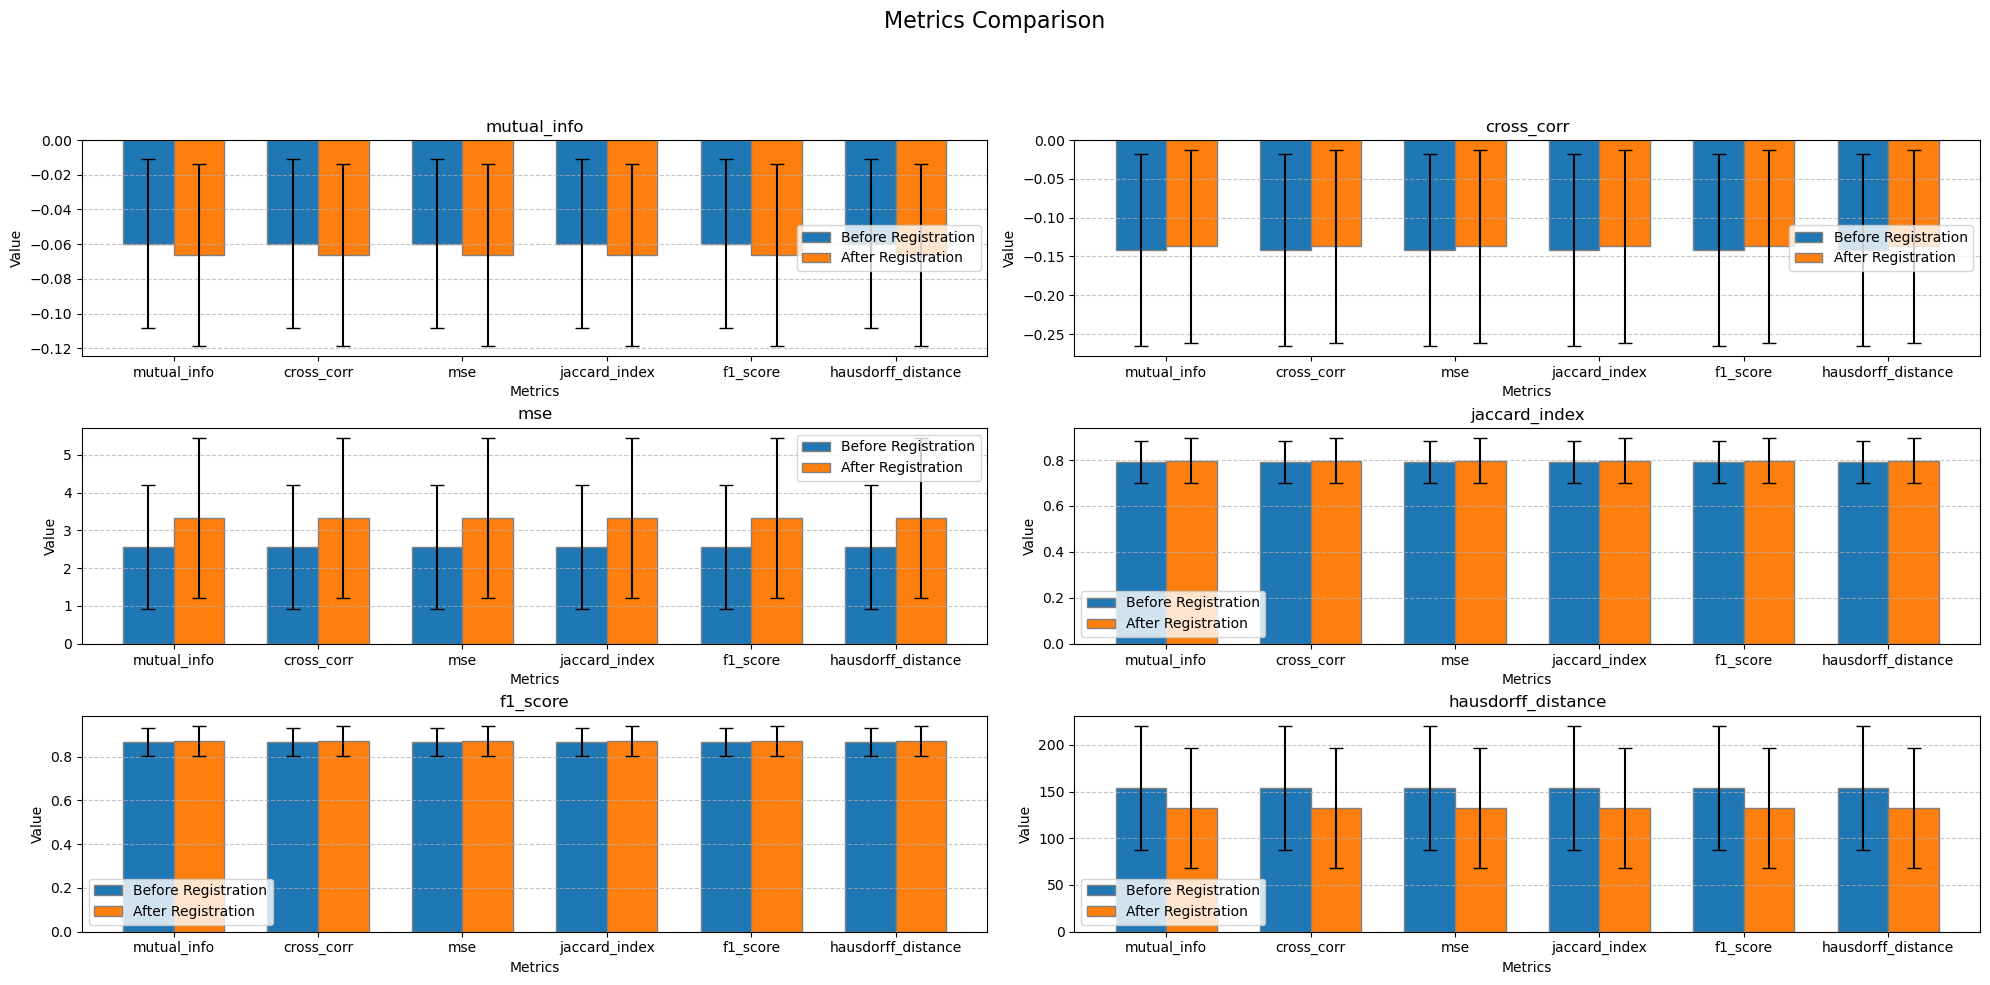

In [76]:
# Plot grouped bar plot with subplots for each metric
fig, axes = plt.subplots(3, 2, figsize=(20, 10))
# Flatten the axes array for easier indexing
axes = axes.flatten()
# Set the figure title
fig.suptitle('Metrics Comparison', fontsize=16)
# Set the bar width
bar_width = 0.35
# Set the bar positions
r1 = np.arange(len(mean_std_df_2))
r2 = [x + bar_width for x in r1]
# Set the colors for the bars
colors = ['#1f77b4', '#ff7f0e']
# Set the bar labels
bar_labels = ['Before Registration', 'After Registration']
# Set the metrics to plot
metrics_to_plot_2 = ['mutual_info', 'cross_corr', 'mse', 'jaccard_index', 'f1_score', 'hausdorff_distance']
# Loop through each metric and plot the bars with error bars

for i, metric in enumerate(metrics_to_plot_2):
    # Filter data for the current metric
    mean_before = mean_std_df_2[mean_std_df_2['metric'] == metric]['mean']
    std_before = mean_std_df_2[mean_std_df_2['metric'] == metric]['std']
    mean_after = mean_std_df_registered_2[mean_std_df_registered_2['metric'] == metric]['mean']
    std_after = mean_std_df_registered_2[mean_std_df_registered_2['metric'] == metric]['std']
    
    # Create the bar plot with error bars
    axes[i].bar(r1, mean_before, yerr=std_before, color=colors[0], width=bar_width, edgecolor='grey', label=bar_labels[0], capsize=5)
    axes[i].bar(r2, mean_after, yerr=std_after, color=colors[1], width=bar_width, edgecolor='grey', label=bar_labels[1], capsize=5)

    # Set the x-ticks and labels
    axes[i].set_xticks([r + bar_width / 2 for r in range(len(mean_std_df_2))])
    axes[i].set_xticklabels(mean_std_df_2['metric'])

    # Set the title and labels
    axes[i].set_title(metric)
    axes[i].set_xlabel('Metrics')
    axes[i].set_ylabel('Value')
    axes[i].legend()

    # Set grid lines
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)
# Adjust the layout
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

In [78]:
# Compute the difference between the metrics of the mean and standard deviation OF the registered images and the regression images
diff_mean_metrics_2 = mean_std_df_registered_2['mean'] - mean_std_df_2['mean']
#Convert the cross correlation and mutual info to absolute values
diff_mean_metrics_2[0] = abs(diff_mean_metrics_2[0])
diff_mean_metrics_2[1] = abs(diff_mean_metrics_2[1])

# Create a DataFrame to store the difference between the metrics
diff_mean_df_2 = pd.DataFrame({
    'metric': mean_std_df_2['metric'],
    'diff_mean': diff_mean_metrics_2
}).reset_index(drop=True)


diff_mean_df_2

,metric,diff_mean
0,mutual_info,0.006309
1,cross_corr,0.004541
2,mse,0.763520
3,jaccard_index,0.005119
4,f1_score,0.002742
5,hausdorff_distance,-21.469419


In [79]:
#Save the dataframe to a csv file
diff_mean_df_2.to_csv('C:/Users/molanre1/Desktop/WSIFIR/scale_7_transform/axis_reg_metrics_diff_mean_df.csv', index=False)

In [80]:
#Create a DataFrame to store the merged images

merged_df_2 = pd.DataFrame(columns=['reg_sampleid', 'axis_sampleid','final_image_parameters', 'final_image_fixed_parameters'])
# Loop through each image and concate to the DataFrame
for i, (reg_sampleid, reg_image) in enumerate(registered_images_scaled.items()):
    # Get the corresponding tbet image
    axis_sampleid, axis_image = axis_images_2[i]

    # Get the transformation matrix
    transformation_matrix = transformation_matrices_scaled[reg_sampleid]

    # Append the metrics to the DataFrame
    merged_df_2 = pd.concat([merged_df_2, pd.DataFrame({
        'reg_sampleid': [reg_sampleid],
        'axis_sampleid': [axis_sampleid],
        'final_image_parameters': [transformation_matrix.parameters],
        'final_image_fixed_parameters': [transformation_matrix.fixed_parameters]
    })], ignore_index=True)

merged_df_2.head(10)

,reg_sampleid,axis_sampleid,final_image_parameters,final_image_fixed_parameters
0,sampleid_709_image,sampleid_101_image,"[0.933521032333374, -0.3585226535797119, 0.358...","[35.215389251708984, 41.98567581176758]"
1,sampleid_710_image,sampleid_107_image,"[0.9572299122810364, 0.28932860493659973, -0.2...","[42.120697021484375, 52.78548049926758]"
2,sampleid_712_image,sampleid_535_image,"[0.938381016254425, 0.3456355035305023, -0.346...","[28.47519302368164, 50.77205276489258]"
3,sampleid_713_image,sampleid_112_image,"[0.948097825050354, 0.318424791097641, -0.3181...","[39.62575912475586, 44.546478271484375]"
4,sampleid_714_image,sampleid_114_image,"[0.924555242061615, -0.3876393735408783, 0.385...","[30.321826934814453, 41.447025299072266]"
5,sampleid_715_image,sampleid_118_image,"[0.9470537900924683, 0.3653676509857178, -0.33...","[36.37406921386719, 45.331546783447266]"
6,sampleid_678_image,sampleid_536_image,"[0.9258753657341003, -0.3778291344642639, 0.37...","[39.46842575073242, 36.75742721557617]"
7,sampleid_679_image,sampleid_537_image,"[0.9503077864646912, 0.3087751865386963, -0.30...","[10.761759757995605, 11.912997245788574]"
8,sampleid_716_image,sampleid_125_image,"[0.9397565722465515, -0.34204691648483276, 0.3...","[31.23196792602539, 37.17987823486328]"
9,sampleid_717_image,sampleid_129_image,"[0.9355201721191406, -0.3532734513282776, 0.35...","[32.858036041259766, 43.60976791381836]"


In [81]:
# Save the merged DataFrame to a CSV file
merged_df_2.to_csv('C:/Users/molanre1/Desktop/WSIFIR/scale_7_transform/xform_reg_to_axis.csv', index=False)

## Affine Registration (Scale 5)

### Load in spatial data

In [82]:
# Loop through each image in sp.images and crop it
cropped_images_3 = {}
for sampleid in sp.images:
    cropped_images_3[sampleid] = tl.crop_xarray_image(sp.images[sampleid], scale=5)[0]


In [83]:
# Convert all images to numpy arrays
cropped_images_arrays_3 = {}
for sampleid, cropped_image in cropped_images_3.items():
    cropped_images_arrays_3[sampleid] = cropped_image.compute()

In [84]:
#Convert all images to ants images
cropped_images_ants_3 = {}
for sampleid, cropped_image in cropped_images_arrays_3.items():
    cropped_images_ants_3[sampleid] = ants.from_numpy(cropped_image)
cropped_images_ants_3

{'sampleid_709_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (1536, 2048)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_101_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (2048, 1536)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_710_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (1536, 2048)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_107_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (2048, 1536)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_712_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (1536, 2048)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_535_

### Pad Images

In [85]:
# Pad the images
padded_images_3 = pad_images_to_same_size(cropped_images_ants_3)
# Convert the padded images to ANTs images
padded_images_ants_3 = {}
for sampleid, padded_image in padded_images_3.items():
    padded_images_ants_3[sampleid] = ants.from_numpy(padded_image)

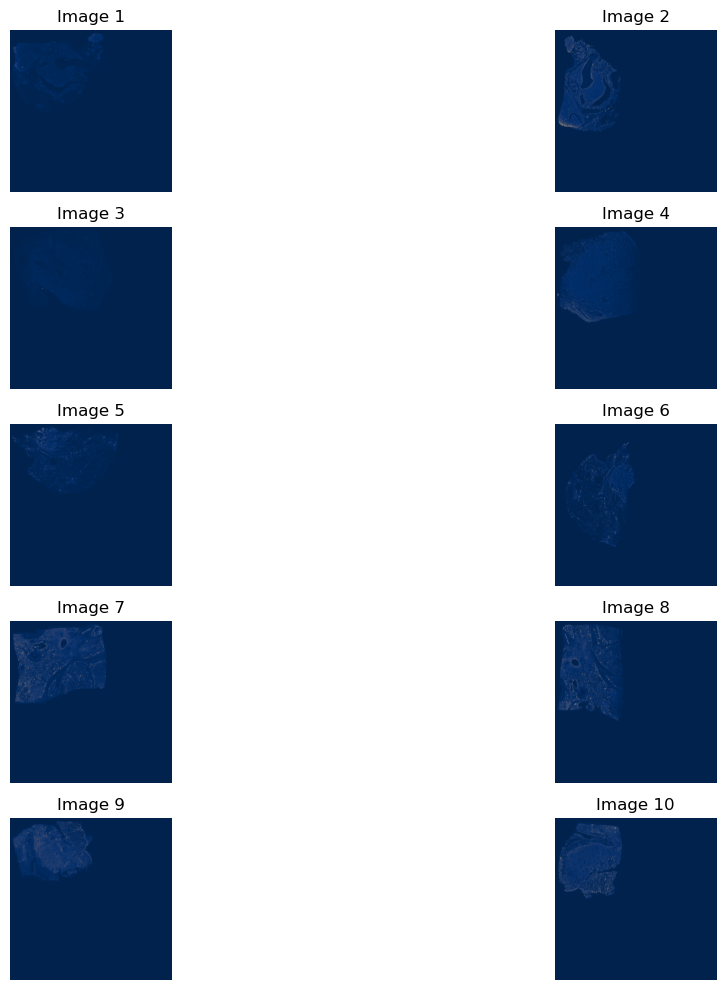

In [86]:
#Plot the first 10 images of padded images using plt with 5 rows and 2 columns
fig, axes = plt.subplots(5, 2, figsize=(15, 10))
axes = axes.flatten()
for i, (sampleid, padded_image) in enumerate(padded_images_ants_3.items()):
    if i < 10:
        axes[i].imshow(padded_image.numpy(), cmap='cividis')
        axes[i].set_title(f'Image {i+1}')
        axes[i].axis('off')
plt.tight_layout()
plt.show()

In [87]:
#Store odd and even images in separate lists: regression and tbet while keeping the key
# Create lists to store regression and tbet image
# images
regression_images_3 = []
axis_images_3 = []
for i, (sampleid, padded_image) in enumerate(padded_images_ants_3.items()):
    if i % 2 == 0:  # Even index
        regression_images_3.append((sampleid, padded_image))
    else:  # Odd index
        axis_images_3.append((sampleid, padded_image))

### Scale and apply registration parameters at lower resolution to higher resolution image

In [88]:
#Compute the scaling factor between an image from scale 7 and scale 5
scaling_factor_2 = compute_scaling_factor(sp.images[f'{list(sp.images)[0]}']['scale5'].image.transform['scale0'].scale[0], sp.images[f'{list(sp.images)[0]}']['scale7'].image.transform['scale0'].scale[0])
#Convert the scaling factors to be floats
scaling_factor_2 = float(scaling_factor_2)


In [95]:
#For each image in the registered images, scale the transformation matrix
transformation_matrices_scaled_2 = {}
for i, (reg_sampleid, reg_image) in enumerate(registered_images_scaled.items()):
    # Get the corresponding axis image
    axis_sampleid, axis_image = axis_images_3[i]

    # Get the transformation matrix
    scaled_transform_path_2 = scale_transform(f'C:/Users/molanre1/Desktop/WSIFIR/scale_7_transform/axis_reg/{reg_sampleid}_to_{axis_sampleid}_0GenericAffine.mat', scaling_factor_2)

    # Store the transformation matrix
    transformation_matrices_scaled_2[reg_sampleid] = scaled_transform_path_2

### ANTS Affine transform

In [96]:
#Perform the registration using the scaled transformation matrix
registered_images_scaled_2 = {}
for i, (reg_sampleid, reg_image) in enumerate(regression_images_3):
    # Get the corresponding axis image
    axis_sampleid, axis_image = axis_images_3[i]

    # Perform registration with the scaled transformation matrix
    registered_image_scaled_2 = ants.registration(fixed=reg_image, moving=axis_image, type_of_transform='Affine', initial_transform=transformation_matrices_scaled_2[reg_sampleid], outprefix=f'C:/Users/molanre1/Desktop/WSIFIR/scale_5_transform/axis_reg/{reg_sampleid}_to_{axis_sampleid}_', verbose=True)

    # Store the registered image
    registered_images_scaled_2[reg_sampleid] = registered_image_scaled_2['warpedmovout']

antsRegistration -d 2 -r C:/Users/molanre1/Desktop/WSIFIR/scale_7_transform/axis_reg/sampleid_709_image_to_sampleid_101_image_0GenericAffine_scaled.mat -m mattes[0000026543B58428,0000026543CC7868,1,32,regular,0.2] -t Affine[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -o [C:/Users/molanre1/Desktop/WSIFIR/scale_5_transform/axis_reg/sampleid_709_image_to_sampleid_101_image_,0000026543B58148,0000026543B5B2A8] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
antsRegistration -d 2 -r C:/Users/molanre1/Desktop/WSIFIR/scale_7_transform/axis_reg/sampleid_710_image_to_sampleid_107_image_0GenericAffine_scaled.mat -m mattes[0000026543B58148,0000026543CC7868,1,32,regular,0.2] -t Affine[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -o [C:/Users/molanre1/Desktop/WSIFIR/scale_5_transform/axis_reg/sampleid_710_image_to_sampleid_107_image_,0000026543B5B2A8,0000026543B58428] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
antsRegistration -d 2 -r C:/Users/molanr

In [97]:
#Read the transformation matrices using ants.read_transform
transformation_matrices_scaled_2 = {}

for i, (reg_sampleid, reg_image) in enumerate(regression_images_3):
    # Get the corresponding axis image
    axis_sampleid, axis_image = axis_images_3[i]
    # Read the transformation matrix
    transformation_matrix = ants.read_transform(f'C:/Users/molanre1/Desktop/WSIFIR/scale_5_transform/axis_reg/{reg_sampleid}_to_{axis_sampleid}_0GenericAffine.mat')
    # Store the transformation matrix
    transformation_matrices_scaled_2[reg_sampleid] = transformation_matrix

# Get the parameters and fixed parameters of the transformation matrices
transformation_parameters_scaled_2 = {}
for sampleid, matrix in transformation_matrices_scaled_2.items():
    transformation_parameters_scaled_2[sampleid] = {
        'parameters': matrix.parameters,
        'fixed_parameters': matrix.fixed_parameters
    }

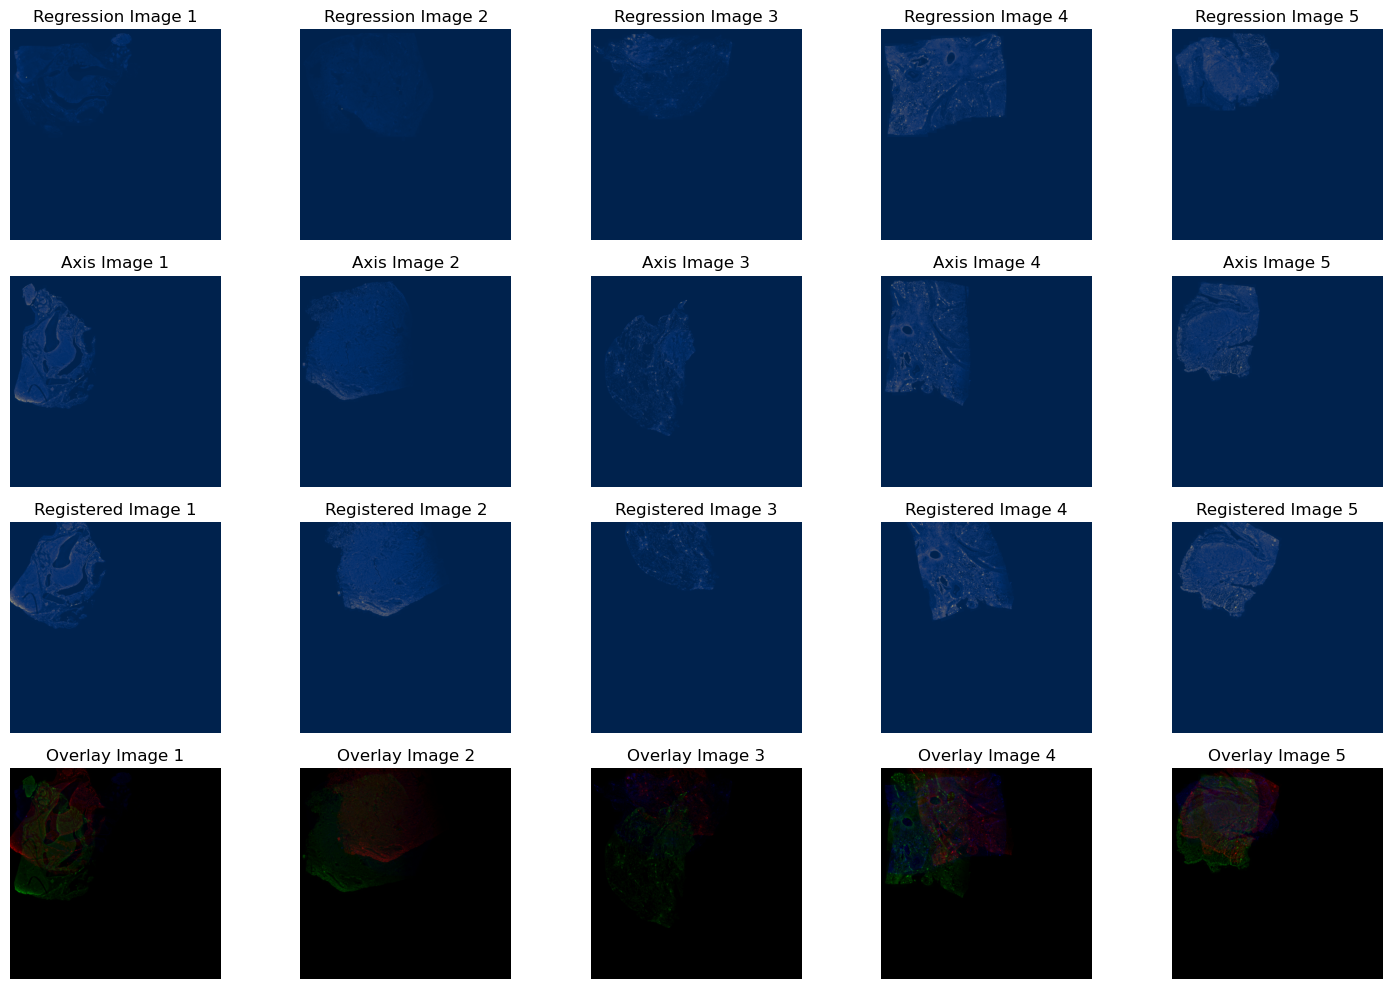

In [99]:
# Plot the first 5 regression images in one row, the corresponding axis images in the second row,
# the registered images in the third row, and the overlay images in the last row.
fig, axes = plt.subplots(4, 5, figsize=(15, 10))
axes = axes.flatten()
# Plot regression images
for i, (sampleid, padded_image) in enumerate(regression_images_3):
    if i < 5:
        axes[i].imshow(padded_image.numpy(), cmap='cividis')
        axes[i].set_title(f'Regression Image {i+1}')
        axes[i].axis('off')
# Plot axis images
for i, (sampleid, padded_image) in enumerate(axis_images_3):
    if i < 5:
        axes[i + 5].imshow(padded_image.numpy(), cmap='cividis')
        axes[i + 5].set_title(f'Axis Image {i+1}')
        axes[i + 5].axis('off')
# Plot registered images
for i, (sampleid, padded_image) in enumerate(registered_images_scaled_2.items()):
    if i < 5:
        axes[i + 10].imshow(padded_image.numpy(), cmap='cividis')
        axes[i + 10].set_title(f'Registered Image {i+1}')
        axes[i + 10].axis('off')
# Plot overlay images
for i, (reg_sampleid, reg_image) in enumerate(regression_images_3):

    if i < 5:
        # Get the corresponding tbet image
        axis_sampleid, axis_image = axis_images_3[i]

        # Get the registered image
        registered_image = registered_images_scaled_2[reg_sampleid]

        # Normalize the images to 0-1 range
        registered_image = (registered_image - registered_image.min()) / (registered_image.max() - registered_image.min())
        axis_image = (axis_image - axis_image.min()) / (axis_image.max() - axis_image.min())
        reg_image = (reg_image - reg_image.min()) / (reg_image.max() - reg_image.min())

        # Create a color image by stacking the images along the third dimension
        color_image = np.zeros((registered_image.shape[0], registered_image.shape[1], 3), dtype=np.float32)
        color_image[..., 0] = registered_image.numpy()  # Red channel (registered image)
        color_image[..., 1] = axis_image.numpy()  # Green channel (tbet image)
        color_image[..., 2] = reg_image.numpy()  # Blue channel (regression image)

        axes[i + 15].imshow(color_image)
        axes[i + 15].set_title(f'Overlay Image {i+1}')
        axes[i + 15].axis('off')

plt.tight_layout()
plt.show()

### Metrics

In [100]:
#Create a DataFrame to store the metrics

metrics_df_3 = pd.DataFrame(columns=['reg_sampleid', 'axis_sampleid', 'mutual_info', 'cross_corr', 'mse', 'jaccard_index', 'f1_score', 'hausdorff_distance'])
# Loop through each image and compute the metrics

for i, (reg_sampleid, reg_image) in enumerate(regression_images_3):

    # Get the corresponding tbet image
    axis_sampleid, axis_image = axis_images_3[i]

    # Compute the metrics
    mutual_info, cross_corr, mse, jaccard_index, f1, hausdorff_distance = compute_metrics(reg_image, axis_image)

    # Append the metrics to the DataFrame
    metrics_df_3 = pd.concat([metrics_df_3, pd.DataFrame({
        'reg_sampleid': [reg_sampleid],
        'axis_sampleid': [axis_sampleid],
        'mutual_info': [mutual_info],
        'cross_corr': [cross_corr],
        'mse': [mse],
        'jaccard_index': [jaccard_index],
        'f1_score': [f1],
        'hausdorff_distance': [hausdorff_distance]
    })], ignore_index=True)


metrics_df_3.head(10)

C:\Users\molanre1\AppData\Local\Temp\2\ipykernel_24632\3510960512.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df_3 = pd.concat([metrics_df_3, pd.DataFrame({


,reg_sampleid,axis_sampleid,mutual_info,cross_corr,mse,jaccard_index,f1_score,hausdorff_distance
0,sampleid_709_image,sampleid_101_image,-0.008959,-0.057489,4.030948,0.780072,0.861833,723.306297
1,sampleid_710_image,sampleid_107_image,-0.015555,-0.204437,1.812223,0.793637,0.878686,282.462387
2,sampleid_712_image,sampleid_535_image,-0.001314,-0.008456,3.982529,0.761046,0.839759,840.000000
3,sampleid_713_image,sampleid_112_image,-0.060520,-0.152444,1.206503,0.763335,0.853734,458.000000
4,sampleid_714_image,sampleid_114_image,-0.081084,-0.198864,1.295168,0.871499,0.925680,295.465734
5,sampleid_715_image,sampleid_118_image,-0.023612,-0.133892,2.515970,0.753596,0.846987,644.870530
6,sampleid_678_image,sampleid_536_image,-0.000393,-0.001366,2.021608,0.899668,0.935250,984.366802
7,sampleid_679_image,sampleid_537_image,-0.000073,-0.000055,0.549901,0.974239,0.983008,996.638851
8,sampleid_716_image,sampleid_125_image,-0.082012,-0.251417,1.059805,0.834455,0.900605,573.289630
9,sampleid_717_image,sampleid_129_image,-0.021715,-0.110740,1.470010,0.812709,0.884165,405.000000


In [101]:
metrics_df_3.drop(columns=['reg_sampleid', 'axis_sampleid'], inplace=True)

In [102]:
# Create a DataFrame to store the metrics between the registered images and the regression images
metrics_df_registered_3 = pd.DataFrame(columns=['reg_sampleid', 'axis_sampleid', 'mutual_info', 'cross_corr', 'mse', 'jaccard_index', 'f1_score', 'hausdorff_distance'])
# Loop through each image and compute the metrics

for i, (reg_sampleid, reg_image) in enumerate(registered_images_scaled_2.items()):
    # Get the corresponding tbet image
    axis_sampleid, axis_image = axis_images_3[i]

    # Compute the metrics
    mutual_info, cross_corr, mse, jaccard_index, f1, hausdorff_distance = compute_metrics(reg_image,axis_image)

    # Append the metrics to the DataFrame
    metrics_df_registered_3 = pd.concat([metrics_df_registered_3, pd.DataFrame({
        'reg_sampleid': [reg_sampleid],
        'axis_sampleid': [axis_sampleid],
        'mutual_info': [mutual_info],
        'cross_corr': [cross_corr],
        'mse': [mse],
        'jaccard_index': [jaccard_index],
        'f1_score': [f1],
        'hausdorff_distance': [hausdorff_distance]
    })], ignore_index=True)

metrics_df_registered_3.head(10)

C:\Users\molanre1\AppData\Local\Temp\2\ipykernel_24632\374039493.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df_registered_3 = pd.concat([metrics_df_registered_3, pd.DataFrame({


,reg_sampleid,axis_sampleid,mutual_info,cross_corr,mse,jaccard_index,f1_score,hausdorff_distance
0,sampleid_709_image,sampleid_101_image,-0.047807,-0.097105,4.707321,0.819307,0.890404,395.345419
1,sampleid_710_image,sampleid_107_image,-0.045645,-0.105370,2.671755,0.738732,0.837331,532.978424
2,sampleid_712_image,sampleid_535_image,-0.000113,-0.000283,5.103500,0.810157,0.874056,1117.770996
3,sampleid_713_image,sampleid_112_image,-0.024661,-0.054057,1.441464,0.734771,0.827807,622.711008
4,sampleid_714_image,sampleid_114_image,-0.101953,-0.223889,1.509412,0.874788,0.928019,275.980072
5,sampleid_715_image,sampleid_118_image,-0.007796,-0.015613,3.964076,0.735139,0.826225,819.088518
6,sampleid_678_image,sampleid_536_image,-0.003301,-0.008696,3.280717,0.879579,0.920781,625.050398
7,sampleid_679_image,sampleid_537_image,-0.000082,-0.000056,1.013154,0.970332,0.980045,1038.193142
8,sampleid_716_image,sampleid_125_image,-0.066803,-0.129430,1.497462,0.814048,0.885737,474.067506
9,sampleid_717_image,sampleid_129_image,-0.043961,-0.167327,1.702536,0.839628,0.903364,218.048160


In [108]:
metrics_df_registered_3.drop(columns=['reg_sampleid', 'axis_sampleid'], inplace=True)

KeyError: "['reg_sampleid', 'axis_sampleid'] not found in axis"

In [109]:
# Compute the mean and standard deviation of the metrics
mean_metrics_3 = metrics_df_3.mean()
std_metrics_3 = metrics_df_3.std()
mean_metrics_registered_3 = metrics_df_registered_3.mean()
std_metrics_registered_3 = metrics_df_registered_3.std()
# Create a DataFrame to store the mean and standard deviation of the metrics
mean_std_df_3 = pd.DataFrame({
    'mean': mean_metrics_3,
    'std': std_metrics_3
}).reset_index()
mean_std_df_3.columns = ['metric', 'mean', 'std']
mean_std_df_registered_3 = pd.DataFrame({
    'mean': mean_metrics_registered_3,
    'std': std_metrics_registered_3
}).reset_index()
mean_std_df_registered_3.columns = ['metric', 'mean', 'std']

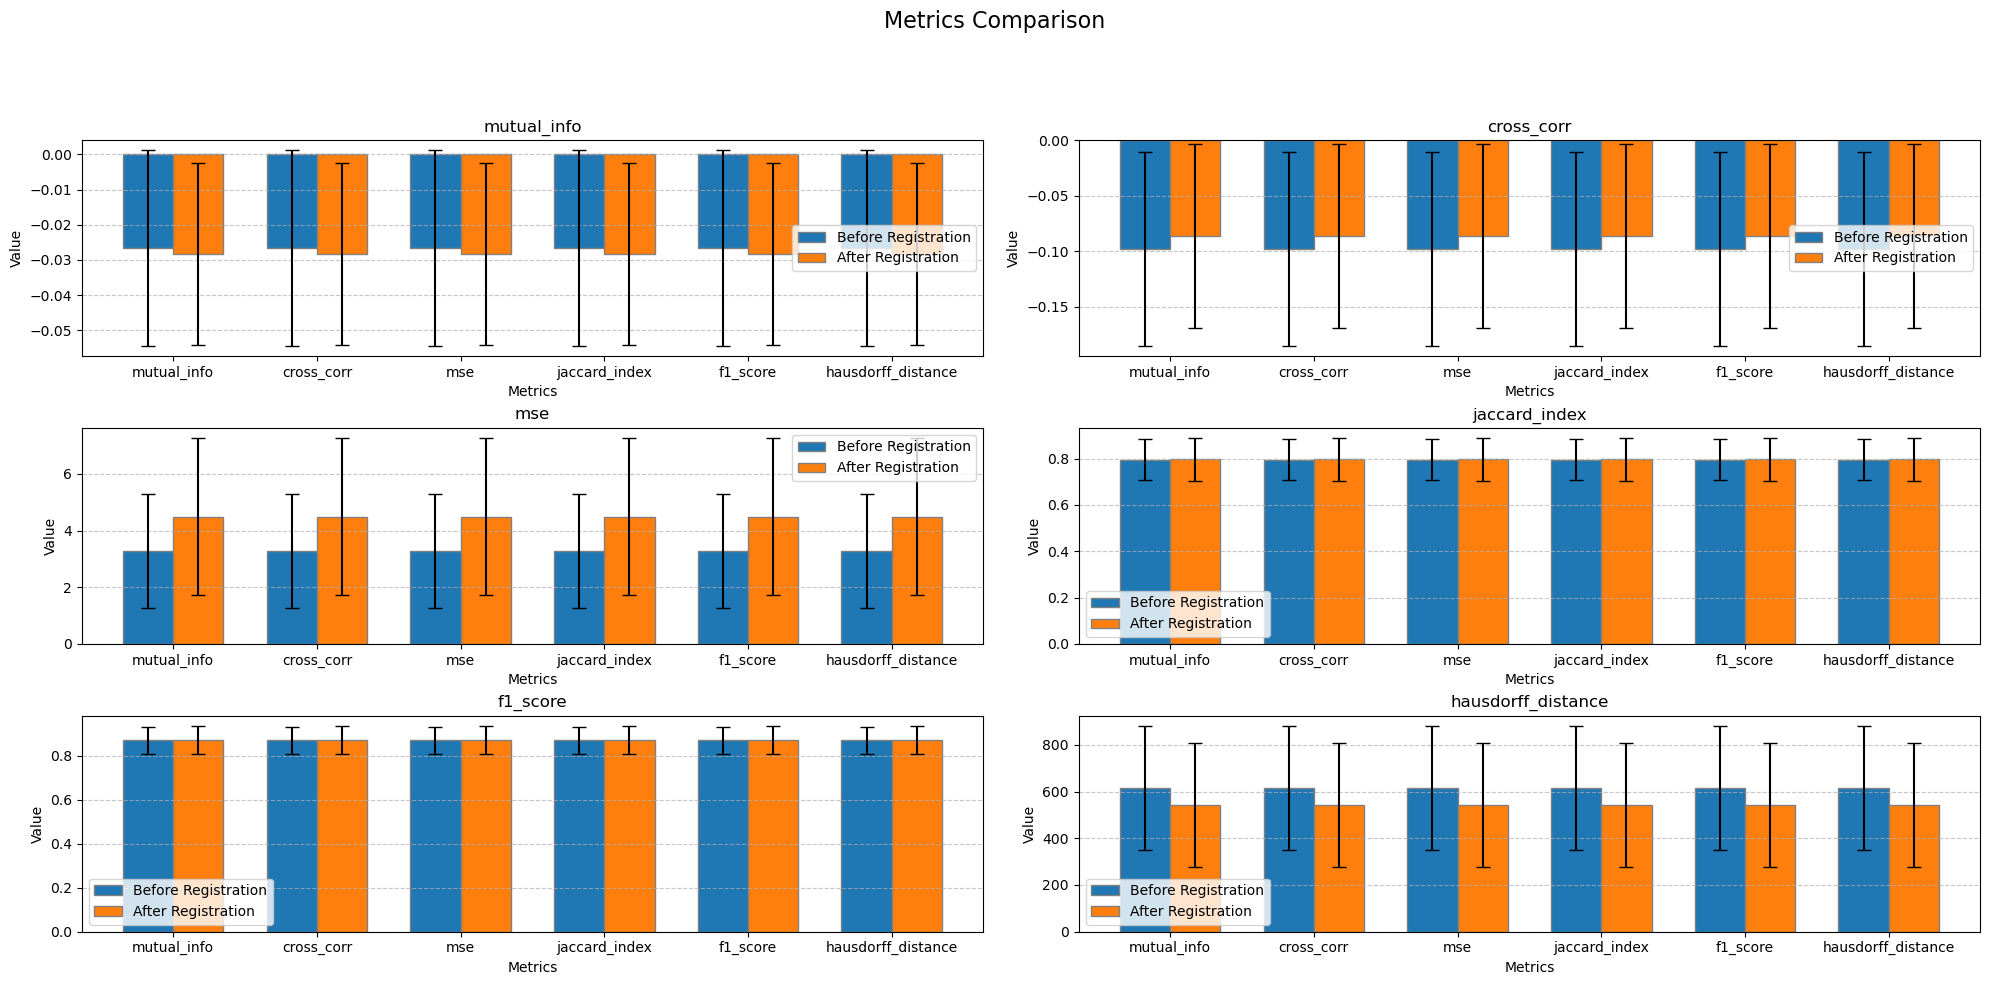

In [105]:
# Plot grouped bar plot with subplots for each metric
fig, axes = plt.subplots(3, 2, figsize=(20, 10))
# Flatten the axes array for easier indexing
axes = axes.flatten()
# Set the figure title
fig.suptitle('Metrics Comparison', fontsize=16)
# Set the bar width
bar_width = 0.35
# Set the bar positions
r1 = np.arange(len(mean_std_df_3))
r2 = [x + bar_width for x in r1]
# Set the colors for the bars
colors = ['#1f77b4', '#ff7f0e']
# Set the bar labels
bar_labels = ['Before Registration', 'After Registration']
# Set the metrics to plot
metrics_to_plot_3 = ['mutual_info', 'cross_corr', 'mse', 'jaccard_index', 'f1_score', 'hausdorff_distance']
# Loop through each metric and plot the bars with error bars

for i, metric in enumerate(metrics_to_plot_3):
    # Filter data for the current metric
    mean_before = mean_std_df_3[mean_std_df_3['metric'] == metric]['mean']
    std_before = mean_std_df_3[mean_std_df_3['metric'] == metric]['std']
    mean_after = mean_std_df_registered_3[mean_std_df_registered_3['metric'] == metric]['mean']
    std_after = mean_std_df_registered_3[mean_std_df_registered_3['metric'] == metric]['std']

    # Create the bar plot with error bars
    axes[i].bar(r1, mean_before, yerr=std_before, color=colors[0], width=bar_width, edgecolor='grey', label=bar_labels[0], capsize=5)
    axes[i].bar(r2, mean_after, yerr=std_after, color=colors[1], width=bar_width, edgecolor='grey', label=bar_labels[1], capsize=5)

    # Set the x-ticks and labels
    axes[i].set_xticks([r + bar_width / 2 for r in range(len(mean_std_df_3))])
    axes[i].set_xticklabels(mean_std_df_3['metric'])


    # Set the title and labels
    axes[i].set_title(metric)
    axes[i].set_xlabel('Metrics')
    axes[i].set_ylabel('Value')
    axes[i].legend()

    # Set grid lines
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)
# Adjust the layout
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

In [110]:
# Compute the difference between the metrics of the mean and standard deviation OF the registered images and the regression images
diff_mean_metrics_3 = mean_std_df_registered_3['mean'] - mean_std_df_3['mean']
#Convert the cross correlation and mutual info to absolute values
diff_mean_metrics_3[0] = abs(diff_mean_metrics_3[0])
diff_mean_metrics_3[1] = abs(diff_mean_metrics_3[1])

# Create a DataFrame to store the difference between the metrics
diff_mean_df_3 = pd.DataFrame({
    'metric': mean_std_df_3['metric'],
    'diff_mean': diff_mean_metrics_3
}).reset_index(drop=True)

diff_mean_df_3


,metric,diff_mean
0,mutual_info,0.001718
1,cross_corr,0.011671
2,mse,1.207588
3,jaccard_index,0.001776
4,f1_score,0.000543
5,hausdorff_distance,-73.213407


In [111]:
#Save the dataframe to a csv file
diff_mean_df_3.to_csv('C:/Users/molanre1/Desktop/WSIFIR/scale_5_transform/axis_reg_metrics_diff_mean_df.csv', index=False)

## Affine Registration (Scale 3)

In [257]:
# Loop through each image in sp.images and crop it
cropped_images_4 = {}
for sampleid in sp.images:
    cropped_images_4[sampleid] = tl.crop_xarray_image(sp.images[sampleid], scale=3)[0]

In [260]:
#Convert all images to numpy arrays
cropped_images_arrays_4 = {}
for sampleid, cropped_image in cropped_images_4.items():
    cropped_images_arrays_4[sampleid] = cropped_image.compute()
    

In [261]:
#Convert all images to ants images
cropped_images_ants_4 = {}
for sampleid, cropped_image in cropped_images_arrays_4.items():
    cropped_images_ants_4[sampleid] = ants.from_numpy(cropped_image)
cropped_images_ants_4


{'sampleid_709_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (6144, 8192)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_101_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (8192, 6144)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_710_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (6144, 8192)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_107_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (8192, 6144)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_712_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (6144, 8192)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_535_

### Pad the images

In [1]:
# Pad the images
padded_images_4 = pad_images_to_same_size(cropped_images_ants_4)
# Convert the padded images to ANTs images
padded_images_ants_4 = {}
for sampleid, padded_image in padded_images_4.items():
    padded_images_ants_4[sampleid] = ants.from_numpy(padded_image)
    

NameError: name 'pad_images_to_same_size' is not defined

In [ ]:
#Plot the first 10 images of padded images using plt with 5 rows and 2 columns
fig, axes = plt.subplots(5, 2, figsize=(15, 10))
axes = axes.flatten()
for i, (sampleid, padded_image) in enumerate(padded_images_ants_4.items()):
    if i < 10:
        axes[i].imshow(padded_image.numpy(), cmap='cividis')
        axes[i].set_title(f'Image {i+1}')
        axes[i].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
#Compute the scaling factor between an image from scale 5 and scale 3
scaling_factor_3 = compute_scaling_factor(sp.images[f'{list(sp.images)[0]}']['scale3'].image.transform['scale0'].scale[0], sp.images[f'{list(sp.images)[0]}']['scale5'].image.transform['scale0'].scale[0])
#Convert the scaling factors to be floats
scaling_factor_3 = float(scaling_factor_3)


In [ ]:

#For each image in the registered images, scale the transformation matrix
for i, (reg_sampleid, reg_image) in enumerate(registered_images_scaled_2.items()):
    # Get the corresponding axis image
    axis_sampleid, axis_image = axis_images[i]

    # Get the transformation matrix
    transform_path = f'C:/Users/molanre1/Desktop/WSIFIR/scale_5_transform/axis_reg/{reg_sampleid}_to_{axis_sampleid}_0GenericAffine.mat'

    # Scale the transformation matrix
    scaled_transform_path = scale_transform(transform_path, scaling_factor_3)
    

### ANTS Affine transform

In [ ]:
#Perform the registration using the scaled transformation matrix
# Create a dictionary to store the registered images
registered_images_scaled_2 = {}
# Loop through each image and perform the registration

for i, (reg_sampleid, reg_image) in enumerate(registered_images_scaled.items()):
    # Get the corresponding axis image
    axis_sampleid, axis_image = axis_images[i]
    # Perform registration using the scaled transformation matrix
    registered_image_scaled_2 = ants.registration(fixed=reg_image, moving=tbet_image, type_of_transform='Affine', aff_metric='MeanSquares', outprefix=f'C:/Users/molanre1/Desktop/WSIFIR/scale_5_transform/reg_tbet/{reg_sampleid}_to_{tbet_sampleid}_', verbose=True)
    # Store the registered image
    registered_images_scaled_2[reg_sampleid] = registered_image_scaled_2['warpedmovout']
    #Apply the transformation to the moving image
    transformed_image_scaled_2 = ants.apply_transforms(fixed=reg_image, moving=tbet_image, transformlist=registered_image_scaled_2['fwdtransforms'])


In [ ]:
#Read the transformation matrices using ants.read_transform
transformation_matrices_scaled_3 = {}

for i, (reg_sampleid, reg_image) in enumerate(registered_images_scaled_2.items()):
    # Get the corresponding axis image
    axis_sampleid, axis_image = axis_images[i]

    # Read the transformation matrix
    transformation_matrix_scaled_3 = ants.read_transform(f'C:/Users/molanre1/Desktop/WSIFIR/scale_5_transform/reg_tbet/{reg_sampleid}_to_{axis_sampleid}_0GenericAffine.mat')
   
    # Store the transformation matrix
    transformation_matrices_scaled_3[reg_sampleid] = transformation_matrix_scaled_3

# Get the parameters and fixed parameters of the transformation matrices
transformation_parameters_scaled_3 = {}
for sampleid, matrix in transformation_matrices_scaled_3.items():
    transformation_parameters_scaled_3[sampleid] = {
        'parameters': matrix.parameters,
        'fixed_parameters': matrix.fixed_parameters
    }


In [ ]:
#overlay the first 10 registered images on the corresponding tbet images and regression images
# using red, green, and blue channels
fig, axes = plt.subplots(5, 2, figsize=(15, 10))
axes = axes.flatten()

for i, (reg_sampleid, reg_image) in enumerate(registered_images_scaled_2.items()):

    # Get the corresponding axis image
    axis_sampleid, axis_image = axis_images[i]
    # Get the registered image
    registered_image_scaled_2 = registered_images_scaled_2[reg_sampleid]

    # Normalize the images to the range [0, 1]

    registered_image_scaled_2 = (registered_image_scaled_2 - registered_image_scaled_2.min()) / (registered_image_scaled_2.max() - registered_image_scaled_2.min())
    axis_image = (axis_image - axis_image.min()) / (axis_image.max() - axis_image.min())
    reg_image = (reg_image - reg_image.min()) / (reg_image.max() - reg_image.min())
    
    # Create a color image by stacking the images along the third dimension
    color_image = np.zeros((registered_image_scaled_2.shape[0], registered_image_scaled_2.shape[1], 3), dtype=np.float32)
    color_image[..., 0] = registered_image_scaled_2.numpy()  # Red channel (registered image)
    color_image[..., 1] = axis_image.numpy()  # Green channel (tbet image)
    color_image[..., 2] = reg_image.numpy()  # Blue channel (regression image)

    if i < 10:
        axes[i].imshow(color_image)
        axes[i].set_title(f'Overlay Image {i+1}')
        axes[i].axis('off')

plt.tight_layout()
plt.show()

### Metrics

In [ ]:
#Create a DataFrame to store the metrics
metrics_df_scaled_3 = pd.DataFrame(columns=['reg_sampleid', 'axis_sampleid', 'mutual_info', 'cross_corr', 'mse', 'jaccard_index', 'f1_score', 'hausdorff_distance'])
# Loop through each image and compute the metrics
for i, (reg_sampleid, reg_image) in enumerate(registered_images_scaled_2.items()):
    # Get the corresponding axis image
    axis_sampleid, axis_image = axis_images[i]

    # Compute the metrics
    mutual_info, cross_corr, mse, jaccard_index, f1, hausdorff_distance = compute_metrics(reg_image, axis_image)

    # Append the metrics to the DataFrame
    metrics_df_scaled_3 = pd.concat([metrics_df_scaled_3, pd.DataFrame({
        'reg_sampleid': [reg_sampleid],
        'axis_sampleid': [axis_sampleid],
        'mutual_info': [mutual_info],
        'cross_corr': [cross_corr],
        'mse': [mse],
        'jaccard_index': [jaccard_index],
        'f1_score': [f1],
        'hausdorff_distance': [hausdorff_distance]
    })], ignore_index=True)

metrics_df_scaled_3.head(10)



In [ ]:
# Create a dataframe to store the metrics between the registered images and the regression images
metrics_df_registered_scaled_3 = pd.DataFrame(columns=['reg_sampleid', 'axis_sampleid', 'mutual_info', 'cross_corr', 'mse', 'jaccard_index', 'f1_score', 'hausdorff_distance'])

# Loop through each image and compute the metrics
for i, (reg_sampleid, reg_image) in enumerate(registered_images_scaled_2.items()):
    # Get the corresponding axis image
    axis_sampleid, axis_image = axis_images[i]

    # Compute the metrics
    mutual_info, cross_corr, mse, jaccard_index, f1, hausdorff_distance = compute_metrics(reg_image, registered_image_scaled_2)

    # Append the metrics to the DataFrame
    metrics_df_registered_scaled_3 = pd.concat([metrics_df_registered_scaled_3, pd.DataFrame({
        'reg_sampleid': [reg_sampleid],
        'axis_sampleid': [axis_sampleid],
        'mutual_info': [mutual_info],
        'cross_corr': [cross_corr],
        'mse': [mse],
        'jaccard_index': [jaccard_index],
        'f1_score': [f1],
        'hausdorff_distance': [hausdorff_distance]
    })], ignore_index=True)

metrics_df_registered_scaled_3.head(10)

In [ ]:
#Compute the difference between the metrics of the registered images and the regression images
metrics_diff_scaled_3 = metrics_df_registered_scaled_3.copy()
metrics_diff_scaled_3['mutual_info'] = metrics_df_registered_scaled_3['mutual_info'] - metrics_df_scaled_3['mutual_info']
metrics_diff_scaled_3['cross_corr'] = metrics_df_registered_scaled_3['cross_corr'] - metrics_df_scaled_3['cross_corr']
metrics_diff_scaled_3['mse'] = metrics_df_registered_scaled_3['mse'] - metrics_df_scaled_3['mse']
metrics_diff_scaled_3['jaccard_index'] = metrics_df_registered_scaled_3['jaccard_index'] - metrics_df_scaled_3['jaccard_index']
metrics_diff_scaled_3['f1_score'] = metrics_df_registered_scaled_3['f1_score'] - metrics_df_scaled_3['f1_score']
metrics_diff_scaled_3['hausdorff_distance'] = metrics_df_registered_scaled_3['hausdorff_distance'] - metrics_df_scaled_3['hausdorff_distance']

In [ ]:
#create a figure with subplots
fig, axs = plt.subplots(3, 2, figsize=(15, 10))
axs = axs.flatten()
# Plot each metric
axs[0].plot(metrics_df_scaled_3['mutual_info'], label='Pre-registration')
axs[0].plot(metrics_df_registered_scaled_3['mutual_info'], label='Post-registration')
axs[0].set_title('Mutual Information')
axs[0].set_xlabel('Sample ID')
axs[0].set_ylabel('Mutual Information')
axs[0].legend()
axs[1].plot(metrics_df_scaled_3['cross_corr'], label='Pre-registration')
axs[1].plot(metrics_df_registered_scaled_3['cross_corr'], label='Post-registration')
axs[1].set_title('Cross Correlation')
axs[1].set_xlabel('Sample ID')
axs[1].set_ylabel('Cross Correlation')
axs[1].legend()
axs[2].plot(metrics_df_scaled_3['mse'], label='Pre-registration')
axs[2].plot(metrics_df_registered_scaled_3['mse'], label='Post-registration')
axs[2].set_title('Mean Squared Error')
axs[2].set_xlabel('Sample ID')
axs[2].set_ylabel('Mean Squared Error')
axs[2].legend()
axs[3].plot(metrics_df_scaled_3['jaccard_index'], label='Pre-registration')
axs[3].plot(metrics_df_registered_scaled_3['jaccard_index'], label='Post-registration')
axs[3].set_title('Jaccard Index')
axs[3].set_xlabel('Sample ID')
axs[3].set_ylabel('Jaccard Index')
axs[3].legend()
axs[4].plot(metrics_df_scaled_3['f1_score'], label='Pre-registration')
axs[4].plot(metrics_df_registered_scaled_3['f1_score'], label='Post-registration')
axs[4].set_title('F1 Score')
axs[4].set_xlabel('Sample ID')
axs[4].set_ylabel('F1 Score')
axs[4].legend()
axs[5].plot(metrics_df_scaled_3['hausdorff_distance'], label='Pre-registration')
axs[5].plot(metrics_df_registered_scaled_3['hausdorff_distance'], label='Post-registration')
axs[5].set_title('Hausdorff Distance')
axs[5].set_xlabel('Sample ID')
axs[5].set_ylabel('Hausdorff Distance')
axs[5].legend()
plt.tight_layout()
plt.show()







In [ ]:
#Convert each set of corresponding tissue slices into a DataFrame
#Each row has the same tissue, but 2 different slices representing the same tissue stained with regression and axis panels
# Create a DataFrame to store the merged images
merged_df_scaled_3 = pd.DataFrame(columns=['reg_sampleid', 'axis_sampleid','final_image_parameters', 'final_image_fixed_parameters'])
# Loop through each image and concate to the DataFrame
for i, (reg_sampleid, reg_image) in enumerate(registered_images_scaled_2.items()):
    #Get the corresponding axis image
    axis_sampleid, axis_image = axis_images[i]
    #Get the transformation matrix
    transformation_matrix_scaled_3 = transformation_matrices_scaled_3[reg_sampleid]
    # Append the metrics to the DataFrame
    
    merged_df_scaled_3 = pd.concat([merged_df_scaled_3, pd.DataFrame({
        'reg_sampleid': [reg_sampleid],
        'axis_sampleid': [axis_sampleid],
        'final_image_parameters': [transformation_matrix_scaled_3.parameters],
        'final_image_fixed_parameters': [transformation_matrix_scaled_3.fixed_parameters]
    })], ignore_index=True)
merged_df_scaled_3.head(10)


In [ ]:
merged_df_scaled_3.to_csv('C:/Users/molanre1/Desktop/WSIFIR/xform_reg_to_axis_scale_3.csv', index=False)